In [2]:
%env THEANO_FLAGS=device=gpu1
import theano

env: THEANO_FLAGS=device=gpu1


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 1: Tesla K80 (CNMeM is enabled with initial size: 19.0% of memory, cuDNN 5110)


In [3]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
import pandas as pd


# Problem & Dataset

* Chemistry is not a mostly loved subject.
* There are various chemical compounds. The problem here is to pronounce a common name knowing its formula.  
* So, we try to learn transition: molecular_formula->common_name.
* If you want, you can replace source and target variables to predict something else (sequential)

In [4]:
molecules = pd.read_csv('molecules.tsv',sep='\t')

def get_xy(x, y):
    global molecules

    is_str = lambda s: type(s) is str
    bool_idxs = x.apply(is_str)& y.apply(is_str)
    
    molecules = molecules[bool_idxs]

    return x[bool_idxs].values, y[bool_idxs].apply(lambda s: ["START"]+list(s)+["END"])

source_seqs, target_seqs = get_xy(molecules.molecular_formula, molecules.common_name) 
#Replace hee


In [5]:
print(molecules.shape)
molecules.head()

(76049, 13)


,Unnamed: 0,alogp,average_mass,common_name,csid,inchi,inchikey,molecular_formula,molecular_weight,monoisotopic_mass,nominal_mass,smiles,xlogp
0,0,0.0,189.1659,Ethyl 3-ethoxy-2-nitroacrylate,28419234,InChI=1/C7H11NO5/c1-3-12-5-6(8(10)11)7(9)13-4-...,NCRBAZRGVXAEOT-UHFFFAOYAR,C_{7}H_{11}NO_{5},189.1659,189.063721,189.0,CCOC=C(C(=O)OCC)[N+](=O)[O-],0.0
1,1,0.0,337.3907,N-Butyl-3-(4-fluorophenyl)-1-phenyl-1H-pyrazol...,3122581,InChI=1/C20H20FN3O/c1-2-3-13-22-20(25)19-14-18...,NELUFAOVAMVTKI-UHFFFAOYAL,C_{20}H_{20}FN_{3}O,337.3907,337.159027,337.0,CCCCNC(=O)c1cc(nn1c2ccccc2)c3ccc(cc3)F,5.0
2,2,0.0,289.4356,N-Butyl-N-sec-butyl-1-benzothiophene-3-carboxa...,48105798,InChI=1/C17H23NOS/c1-4-6-11-18(13(3)5-2)17(19)...,NBFKIRKJPHGZKL-UHFFFAOYAC,C_{17}H_{23}NOS,289.4356,289.150024,289.0,CCCCN(C(C)CC)C(=O)c1csc2c1cccc2,0.0
3,3,0.0,399.4867,2-{6-[(2S)-2-Butanyl]-2-(2-methyl-2-propanyl)-...,6383180,InChI=1/C21H29N5O3/c1-6-12(2)24-10-14-18(20(24...,VWCDHRSVOZJHDO-LBPRGKRZBX,C_{21}H_{29}N_{5}O_{3},399.4867,399.227051,399.0,O=C3C=2N(c1cc(nn1C(=O)C=2CN3[C@@H](C)CC)C(C)(C...,1.9
4,4,0.0,332.2367,"4-Bromo-5-[(3-hydroxy-2,3-dimethyl-2-butanyl)a...",57112886,InChI=1/C13H22BrN3O2/c1-6-7-17-11(18)10(14)9(8...,UNUIIQXCUFRMON-UHFFFAOYAG,C_{13}H_{22}BrN_{3}O_{2},332.2367,331.089539,331.0,CCCn1c(=O)c(c(cn1)NC(C)(C)C(C)(C)O)Br,0.0


In [6]:
for source, target in zip(source_seqs[:5],target_seqs[:5]):
    print( source,':',"".join(target[1:-1]))

C_{7}H_{11}NO_{5} : Ethyl 3-ethoxy-2-nitroacrylate
C_{20}H_{20}FN_{3}O : N-Butyl-3-(4-fluorophenyl)-1-phenyl-1H-pyrazole-5-carboxamide
C_{17}H_{23}NOS : N-Butyl-N-sec-butyl-1-benzothiophene-3-carboxamide
C_{21}H_{29}N_{5}O_{3} : 2-{6-[(2S)-2-Butanyl]-2-(2-methyl-2-propanyl)-5,8-dioxo-5,6,7,8-tetrahydro-4H-pyrazolo[1,5-a]pyrrolo[3,4-d]pyrimidin-4-yl}-N-cyclopropylacetamide
C_{13}H_{22}BrN_{3}O_{2} : 4-Bromo-5-[(3-hydroxy-2,3-dimethyl-2-butanyl)amino]-2-propyl-3(2H)-pyridazinone


In [7]:
target_letters = list(set([token for ts in target_seqs for token in ts]))
target_letter_to_ix = {ph:i for i,ph in enumerate(target_letters)}

ix_to_target_letter = {i : ph for i, ph in enumerate(target_letters)}

In [8]:
source_letters = list(set([token for word in source_seqs for token in word]))
source_letter_to_ix = {l:i for i,l in enumerate(source_letters)}

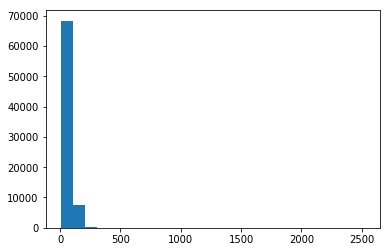

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,target_seqs)),bins=25);

# Truncate names longer than MAX_LEN characters. This can be changed
MAX_LEN = min([150,max(list(map(len,target_seqs)))])

### Cast everything from symbols into matrix of int32. Pad with -1

In [11]:
def as_matrix(sequences,token_to_i, max_len=None,PAX_ix=-1):
    """
    Converts several sequences of tokens to a matrix, edible a neural network.
    Crops at max_len(if given), pads shorter sequences with -1 or PAD_ix.
    """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int8') -1
    for i,seq in enumerate(sequences):
        
        row_ix = [token_to_i.get(_, 0) for _ in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix


In [12]:
print(as_matrix(source_seqs[:10],source_letter_to_ix))

[[45 13 18 46 50 25 13 18  6  6 50 41 36 13 18 14 50 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [45 13 18 17  0 50 25 13 18 17  0 50  7 41 13 18 24 50 36 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [45 13 18  6 46 50 25 13 18 17 24 50 41 36 33 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1]
 [45 13 18 17  6 50 25 13 18 17 11 50 41 13 18 14 50 36 13 18 24 50 -1 -1
  -1 -1 -1 -1]
 [45 13 18  6 24 50 25 13 18 17 17 50 35 20 41 13 18 24 50 36 13 18 17 50
  -1 -1 -1 -1]
 [45 13 18  6 39 50 25 13 18  6 14 50 41 13 18 24 50 36 13 18 24 50 -1 -1
  -1 -1 -1 -1]
 [45 13 18 17 46 50 25 13 18 17 24 50 45 29 13 18 17 50 41 36 13 18 14 50
  -1 -1 -1 -1]
 [45 13 18  6 17 50 25 13 18  6 17 50  7 13 18 24 50 41 13 18 24 50 36 13
  18 17 50 33]
 [45 13 18  6 46 50 25 13 18  6 11 50 45 29 41 13 18 17 50 36 -1 -1 -1 -1
  -1 -1 -1 -1]
 [45 13 18  6  6 50 25 13 18  6 11 50 45 29 41 13 18  9 50 -1 -1 -1 -1 -1
  -1 -1 -1 -1]]


# Input variables

In [13]:
input_sequence = T.matrix('token sequence','int32')
target_target_letters = T.matrix('target target_letters','int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* Input sequence
* One-hot / embedding
* Encoder recurrent layer(s)
* Decoder recurrent layer(s)
* Softmax layer to predict probabilities

In [14]:
from lasagne.layers import *
from lasagne.nonlinearities import*

##ENCODER
l_in = InputLayer(shape=(None, None), input_var=input_sequence)
l_mask = InputLayer(shape=(None, None), input_var=T.neq(input_sequence,-1)) 

l_emb = EmbeddingLayer(l_in, len(source_letters), 8)

l_rnn = GRULayer(l_emb, 1024, only_return_final=True, mask_input=l_mask, grad_clipping = 10)

In [15]:
##DECODER
dec_in = InputLayer(shape=(None, None), input_var=target_target_letters)
dec_mask = InputLayer(shape=(None, None), input_var=T.neq(target_target_letters,-1))

# WARNING! if it's lstm use cell_init, not hid_init

dec_emb = EmbeddingLayer(dec_in, len(target_letters), 8)
dec_rnn = GRULayer(dec_emb, 1024, hid_init = l_rnn, mask_input = dec_mask, grad_clipping = 10)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
dec_rnn_flat = reshape(dec_rnn, (-1,dec_rnn.output_shape[-1]))

# l_out = <a layer that predicts next token probabilities given dec_rnn_flat>
l_out = DenseLayer(dec_rnn_flat, len(target_letters), nonlinearity = softmax)

In [16]:
# Model weights
weights = get_all_params(l_out,trainable=True)
#print weights

In [17]:
network_output = get_output(l_out)
network_output = network_output.reshape([target_target_letters.shape[0], target_target_letters.shape[1],-1])
#If you use dropout do not forget to create deterministic version for evaluation

In [18]:
predictions_flat = network_output[:,:-1,:].reshape([-1,len(target_letters)])
targets = target_target_letters[:,1:].ravel()

#do not count loss for '-1' tokens
mask = T.nonzero(T.neq(targets,-1))

# loss = <compute me! You will require predictions_flat, targets and mask. Loss must be scalar>
loss = (lasagne.objectives.categorical_crossentropy(predictions_flat[mask], targets[mask])).mean()

updates = lasagne.updates.adam(loss, weights)

# Compiling it

In [19]:
#training
train = theano.function([input_sequence, target_target_letters], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_target_letters], loss, allow_input_downcast=True)

# Generation

We now need to implement a function that generates output sequence given input.

Such function must work thusly:
```
Init:
x = input
y = ["START"]

While not_too_long:
  p(y_next|x,y) = probabilities of next letter for y
  
  y_next ~ p(y_next|x,y)
  
  y.append(y_next)
  
  if y_next == "END":
      break
```

In [20]:
# network_output = <network output reshaped to [batch,tick,token] format>
#compile the function that computes probabilities for next token given previous text.

# last_word_probas = <a matrix [batch_i, decoder_n_tokens] of network output for last time step>
last_word_probas = network_output[:, -1]
# probs = <a function that predicts probabilities coming after the last token
probs = theano.function([input_sequence, target_target_letters], last_word_probas, allow_input_downcast=True)

In [21]:
def generate_output(input,
                    output_prefix = ("START",),
                    END_token="END",
                    temperature=1,
                    sample=True):
    
    """
    Implement a function that generates output sequence given input.
    
    We recommend (but not require) you to use the pseudo-code above and inline instructions.
    """
    
    output = list(output_prefix)
    
    while True:
#         next_y_probs = <a vector of probabilities of the next token>
#         next_y_probs = <apply temperature>

        next_y_probs = probs(as_matrix([input],source_letter_to_ix),
                             as_matrix([output],target_letter_to_ix))[0]
        next_y_probs = next_y_probs**temperature / np.sum(next_y_probs**temperature)
    
        if sample:
#             next_y = <token sampled with these probabilities (string character)>
            next_y = ix_to_target_letter[np.random.choice(np.arange(len(target_letters)), 
                                                          p=next_y_probs)]
        else:
#             next_y = <most take likely token>
            next_y = ix_to_target_letter[np.argmax(next_y_probs)]
        
        assert type(next_y) is str, "please return token(string/character), not it's index"
        
        output.append(next_y)

        if next_y==END_token:
            break
            
    return output



# Model training

In [22]:
source_seqs = np.array(source_seqs)
target_seqs = np.array(target_seqs)

In [23]:
def sample_batch(source_seqs,target_seqs, batch_size):
    """samples a random batch of source and target sequences, batch_size elements"""
    batch_ix = np.random.randint(0,len(source_seqs),size=batch_size)
    source_seqs_batch=as_matrix(source_seqs[batch_ix],source_letter_to_ix) 
    target_seqs_batch=as_matrix(target_seqs[batch_ix],target_letter_to_ix)
    
    return source_seqs_batch,target_seqs_batch

In [24]:
from tqdm import trange

#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 256

#how many training sequences are processed in a single function call
batch_size=10


for epoch in trange(n_epochs):


    avg_cost = 0;
    
    for _ in tqdm_notebook(range(batches_per_epoch)):
        
        x,y = sample_batch(source_seqs,target_seqs,batch_size)
        avg_cost += train(x, y).mean()
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))
    for i in range(5):
        ind = np.random.randint(len(source_seqs))
        print (source_seqs[ind],':', ''.join(generate_output(source_seqs[ind],sample=True)[1:-1]))



The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 0 average loss = 3.44398963265121
C_{14}H_{13}IN_{2}O_{3}S : 4-(x-iNC-oy3y(h3heehyup[hyyte-2-nuetiely3thnoxt]pnlldod3n5
C_{17}H_{18}N_{2}O_{4} : N-(-(r-4[lyym-b-lnn6-3h)-alh-mnh(eyb,2cx2e4xa)yo1re-2ylamhb3ee-ap-e5mldni-o3ih1rott-leal(
C_{16}H_{22}N_{6}O : (-(e7(x-ye-14--ye2b-()t4spy{-ol4nyoipx-a-Haul-ll-ec)taeptc4bba4xlynpl-)mdlihi]t--ttttibtylohayc-onoar--atehrnya-odcdhpomy4ftltne8zoihg,i-m-n-aa4ui
C_{15}H_{17}NO_{2}S : 4-4(Mhb[-r-sn--(ep4h1dRxa(2-h(-ycy-trlrh3hol)r,x}ey-treoyanilhox--e -r4hl-e1hnlfrtnn2iiip1oiy3pytnhhi2iaea](iecn,yyhp-aH1-be4
C_{10}H_{11}F_{4}N_{3}O : (-21tmo(1x-xy1)fnoeyl3-holy2(cr-olhi3yttot,nil,lpdzr)xcreml]pi-lrzp-o-2x1dplol-i,lo2ih-hyiienHrlioa-yh-nayoereao


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 1 average loss = 3.3208509627729654
C_{197}H_{247}N_{76}O_{101}P_{19}S_{19} : Et2yAoyANi-h-diot,5yeoidf,yil-3i,ey-i1ohd)1b,-t1tmflNpim3no7ydncom1zlaaaaelae-ce-ol
C_{9}H_{7}IN_{2}OS : 4-(h]t(lrd2-o4[e2o)lmp--l2pNyy2n[(y--ott-o-l)2-yp2bt),opyleynl
C_{9}H_{6}ClF_{4}N_{3} : 32o(2oytSxthlx6)ti-d-o2yhyhh-{y,)1b-ddilhxdl,-3ll-imall-iee
C_{13}H_{19}N_{5}O_{2} : 2-E--p-MNFzl4cabHoy43e-
C_{15}H_{21}N_{3}O : 4,(h-3Clcnr-bpmlo,5233oex,l-3]tl5fy5yedy,)u-a1lrym-uii)undalcg,iemnl-ooyyym]i


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 2 average loss = 3.263037499971688
C_{10}H_{9}N_{3}O_{4} : 23[4oi0[-eBen-xh(y-),upypii),orlrmosoxoali4lf1r4xsn{5ynr,bh-y-dd(eeo[ercyh-,py-iy92-xyoatno,mhzmiadeycla1ebypidlm,Heaectea9oi-dl-],,m112,thto,
C_{19}H_{19}NO_{4} : E-(-2-l3d-,-N5--h(,olyyls(l5t--ny5ym4raonplm-qraxu-edznn32,ine-olxete[drl-i3pcineora)(]-na51
C_{26}H_{32}N_{4}O_{4}S : 3-(3--hot5eyy2y(fy-e3h-exH,razytm-rhl-yNnpanernnhntacia2)-n}bzt]-obcn-ie-l}meabiln-ninbrmo--eediet-aolatneyonbapihi.-
C_{14}H_{18}N_{6}O : 1-({-ltl[-xlh(opnyl-nr-lo)-hydl-n5a1-xllrl4--ocnlzrpxntdcneeeelec,nymnlicnxl
C_{13}H_{16}BNO_{2}S : N(1y2-,rpl[hceyzl)n,h-n--oyn-lf-xhtlH.ynaie


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 3 average loss = 3.2497588340193033
C_{16}H_{23}N_{3}O_{2} : 1-E((mtyr3ehh2m(de4y-)-i-ri-yn,net-l4iilz4tn3nhled1py4rrl-gi-[e1]n-teiao]o-]lpieciboyamttl]de
C_{16}H_{14}N_{2}OS : 1-C2tez-Dpliy-loem-lm2el-lyelol-q-,-1hhiyol3adez(
C_{10}H_{10}FNO_{3} : --(2[ieo3mhaty)pye4m-ynhcllmypdhetloel-z--t~moai]t,m}me--yyiini-e5a]iirpnialmyi4b,-na-1lb:cee
C_{12}H_{22}N_{4} : N-{,4e lFNo,m1r-Sy7yal3-ly,4-rye-zyiy(3l)lpe2rplpeaya
C_{25}H_{19}NO_{6}S : -2-i--(6lh),ymth-[4l(y2t-toy2yz1x)y2t222)z-3n


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 4 average loss = 3.246979992836714
C_{16}H_{21}N_{3}O_{4}S : N-6)ytl[)nt[lly-lrpe2y)hnl34bhm-hh}t-p1yibin(4alo4-ino-epc}iatpeaiidazoodoaaacaiyy
C_{16}H_{12}N_{2}O_{3} : N-{2o[34hl-o2lynorra[l1a22--l-lpypheerhym,m)zinni-bhroeerh2d-3-anltoiorel-H]llh-euyoeardopn-ritlc4pioo'ah3d
C_{22}H_{29}N_{3}O_{6}S : 2-21nme1mmolaxu1o)urxl2pynNdxmaihd42-4tbnl
C_{21}H_{24}N_{4}O_{5}S_{2} : N()halyryro-Bp6hen-e(olh()5i--d4t2t-orntt-n)ih-h-y-dz(h1-tlnzyltim(n-hu-bndbate(epurly
C_{15}H_{23}ClN_{2} : 2-[1-B15u8hhptxoepmyh(xNnt1H-ol]idiymi2exnxo]chhdr-)dmta


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 5 average loss = 3.2415336603298783
C_{17}H_{15}ClN_{4}O_{3}S_{2} : 2-O3y(xoHn--2i-Oyhoa)[ht]o,a-z3dh2Nlp41ynoa}ptn-yz-pd2]ytzmmnziyaomo)eaoadam)licboid)ef-,renliie3hu
C_{14}H_{15}BrClNO_{3} : 7-)rcl3-y-mZ-hmpa-i-2r5-xm1262no-yclN(ny(lo-yibol1ycuua-1(iezoa-ac
C_{14}H_{15}BrF_{2}N_{2}O_{2} : 3-Al-o,4-znorxo)2yc1hllbha,ollh)2-l)[-5-Sd-l(}emdoleatleom1dcllepya,nlHbrueeaaieh rlieHmiha
C_{23}H_{25}N_{3}O_{5} : Ntt[-e(oroz-ct-z4eelltl-hooionno-edN(ynne--4rt-fo---nn]4-oancroep}a tinxtd-[ob-obhpne-acceentpe7
C_{11}H_{23}N_{3}O_{3} : N~RC--(M5norroehna)ao-n([dpl46-olex-hhr]x-5ntnb-labee)xnt


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 6 average loss = 3.236410168930888
C_{17}H_{24}BBrO_{3} : (1[(-CetFho3p--yp-)(ddodlb-e(biny)lphoaylopram2nhnl6rld-tp1-ayhc:ptenp1zl
C_{15}H_{23}ClN_{2}O_{2} : M-C([-3--3rh-1eh)yh---n1yyyhl5-iv1-)-x~yrye4ytmi,yi-ml-)de-ayraehuted-oiemlezodoeh2n4oen-)reyipylc-yno42n3e5e1ee-y-ycn3aal]c-4ot,2l-sHid]rbe-o
C_{13}H_{9}BrCl_{2}N_{2}O : N-[1soy(ioahp3h-([ythiido-lylypll5i)x]h)enn-iyilll--elod-il5
C_{16}H_{20}FN_{3}O_{2}S : M-['-3--5o12,iy--yo-i2hN3o.,yem1yionuttlpmlor3xt-l4a--ibnt)en-eeyedonoqlepi-),n],r
C_{7}HClF_{4}N_{2}O : 1-tr--o4m-,o-hr--tolo-yyml-t1nylnyt]xpnx-ey)p3alyliaulinm2hncadmn1(


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 7 average loss = 3.261249417439103
C_{20}H_{24}N_{2}O_{2} : M-2-3-[Nxm4ie-4e3c{-)ib3(yia,h-nt)yz2xm)e]-pl-yt-ydenl5teill-ntetryeamexnaioley5-iil,aa,e- oa nt,]ainp-lp),oa
C_{10}H_{12}N_{4}S : N-((l-N2Ih2hopyni[mzmhe-pn-3sftl,]Heo]-hi]nrhlp]zr-5ytpne)ndyzidrze3,ztno-rob-de-1almeo4,neaizb),t2siy,a5paaHiomeema-lcymel:a-1ahlHhoox:zrix1mahpeueaci,mnl5,2H)ixobx2yabp,]mrtr[aondct-noe-nodenaamnc3o)5tlo2intoxy,d:2iidn,n,-
C_{13}H_{13}BrFNO_{3}S : 13{-2,yyno(4o4l-)dyh-i1N)12a1r1rizh,sl3eynn-l,i
C_{14}H_{18}F_{3}N_{3}O_{4} : N--((lyD-oelDryyorhofre-xyr-pmyo4oxi-lo1ot,cnx-1pltpl-1)miayeabx32-omt4em3inix-ilai etniu8i,4n,[yarre2e-z1(xx-ct)pmge r-)dHbsdiax2oh2plc--aeesa-2yn,ialrti6,ge-e
C_{14}H_{17}ClN_{2} : 3-t[DdtoD-tnoly2lfdHe-lolhloeylollborimaoihaope-Heyoon(,e,i)o3ix4h-e5yl2i4a]a-2yriot)mleoeortn-m[yiand3miooryoxzlamla 1)euomxnyyhtiimrata,-o5(nleae5eH


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 8 average loss = 3.244901727885008
C_{12}H_{24}N_{2}O : 4-[Cm(ill-1{ntrto)ix4y1xeth-n3z-,x)e2-lp--ohoine
C_{19}H_{19}BrN_{4}O_{2} : N-C2-( n6-mbyoxo--eyma,o-oid-h(or,nyyolhxr1-yto-)o-eonlhmzeapol noyeell
C_{40}H_{44}N_{6}O_{11}S : 2C[1ll2l-2(oi4(oh-yd3c)xt1-[itldb)h)npin}to,)e4nrn(nioey11r-o-lixphymml22dxhyti1pd--enoo
C_{16}H_{15}BrClNO_{2} : 6-({, C3y(orh25-(-bmdl--nl-,o1o-1oiylnpanylry.-t3o-yyipcdi,(a-tmhll-hllolma lmyrat-oymrrno-pea]c--euim)9dn
C_{27}H_{21}FN_{2}O_{2} : 5~IF---y-hh-r2ilho-o-h-xo-d2nlhml2)p1ier5zryehiieoetxHn-i)x6oornrrlehame6mmomdde


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 9 average loss = 3.2207160480320454
C_{18}H_{19}BrFNO_{3} : N,(-,--[r-n4oor22(nlo-otb-trli)ymlae-(-n]dxnt)p2y-yehnnyhhloyciexhilehryto)-n)oa
C_{18}H_{34}N_{6}O_{6} : N,((B5h-m)mmo yite,)n-oe]yp~ac,tlrhn-iypooupt-mruanory-d)s-tmt-ehxalhh)1h4xelnelticy-d
C_{16}H_{27}N_{3}O : 5-Ss-mc1-2yy(too[t2p-yc)N-cl-y)eohy-n))bpn2-erhnya)i-lnrmceh)h-hdrayen4hn2atrxdee)mhlo-lrnhnnci-amc
C_{19}H_{23}ClN_{4}O_{3} : E--2{Bhr-llco-thih)H2)epo)on[---p]tm-hehni)a-a4-a]l4y--fleolezre1mnep-n-2aem
C_{13}H_{18}N_{4}O_{2} : 2-(27e)-l~mN23-e-,(l2-p)aymr2t-42poy-(1r-y2x-i)zo}-1sarh7taaoh


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 10 average loss = 3.1907958230003715
C_{15}H_{23}N_{3}O_{5} : 6-()-yC-ium5---ty)ehno-1ayHoyb )oxhi-crmealeay}nipe4ymli-eoee
C_{14}H_{16}F_{2}N_{2}O_{2} : (-(Ii-3--{cz,ylhyennnhinnl-o[xdt]s7-ahill
C_{13}H_{23}N_{3}O : 32Ae(Ali-i--phtptephph-{tyy)aozlem[d]yroyria-]rz)1e-u
C_{22}H_{30}N_{2}O_{3}S : N-((--x(-y4a--m1ott-mNntmr(imiHiiomyrblx2pdr--nomaprlmhho-
C_{10}H_{22}N_{2}O_{2} : E2-(yi-t-B-pinr(rplheyopn[mrd-r)lp-mNoo(-2peraor)-}r-atohyoeyltl5l-eecd---pnayrlyi-aner


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 11 average loss = 3.0892637623474
C_{18}H_{18}N_{2}O_{3}S : 3-A,21o(yo,--,o-thy)ehhry2f--bemN,e-d ,-dnda,i[ozmlodiobatmmnoeHe-Hca
C_{18}H_{22}FNO_{4} : 2-e21(Chio-[prnnhy62thoh-o-o-N--yln-eylr]zmopoHmo)r6]xna
C_{9}H_{9}NO_{2} : (7[Shr3--1-eTseiNih)dpe--3-22ylad,3hi4o-iahylaox]3inyly}ir
C_{27}H_{31}N_{3}O_{6}S : E-N(5(oyoton31b-,4ylpi--no-2rrorthr-un-)-(4ylboiainl(-fyet-4ial]acyl-le-ylinnhe33]nyz)ylmyfbnryan
C_{13}H_{24}N_{2}O_{2}S : B~({-(3haN-chao4yylyliyi43pryylh


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 12 average loss = 2.900482493452728
C_{13}H_{16}ClN_{3}S : 4-(4o9eti--cyethete~1-2tyl)-yo)~363mHendulnuhylacy]-
C_{22}H_{24}N_{4}O_{4} : 4-Aom-p(phen-e)l,thyl-myo-hyl)-n--]---4,
C_{21}H_{19}N_{5}O_{2}S : C-((3[thoBylMeot3--nyl)y--u(,(i-[1n1-maihbdet-,)3a}itylpaeoe
C_{19}H_{24}FN_{5}O_{2}S : 2-C4,14DDo-)-eih5mpre2(yl)zhoyl)p-1ii[o-on34m6mbmthhhtyr}peie,ithxyl-cyccoMehdn:4poh)qbhe
C_{12}H_{18}N_{2} : 2-(E4Mlh---6ouxyy)-etl)hp4Hnadph8pp---thzrnnomnyl)ec]mo


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 13 average loss = 2.602095696143806
C_{19}H_{29}N_{3}O_{2} : E-tet[Emoo2tooTorhyenyo]3xyp-cenooan-cho-3--aniin-mci5c,-}4-]1-1-)-te
C_{13}H_{24}N_{2} : 1-Z21 nhhoetethylpoyu)]cethle
C_{11}H_{21}F_{3}N_{2}O_{3}S : 8eth3-RneSitetyl)pyl)odineny)nylyol]1-{yprba-io5---pylri-myl}nethetodaco)moininethad
C_{21}H_{26}N_{2}O_{2} : 1-Pyl2o--A-muobhyl2cuacl341:3s1phiopyldylrraathylzooipeticxdobnipo:d]--prq,xenide
C_{18}H_{19}N_{5}O_{3}S : N-{([tyl--~-3-S5mono-yl-tixanocenidta2-nylace]--7idioas4-6-fl4tenidetha-2myl)2-noocro--nidoe


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 14 average loss = 2.3448989940807223
C_{15}H_{18}ClNO_{6} : 2-[3-hho2o[xzenrodlzoluidzripiyl)--3qo--iiediolyl)-35,uithhhena2pa2-idinamaziobenrzins letinyllendo8-re
C_{20}H_{21}N_{5}O_{2} : N-(buoo[i4H4-Rdethyl--thyl)xo0nyethyl}-2N-[Siitri-oa--fene
C_{47}H_{57}N_{3}O_{7} : 1,hyll(-Cenros -fethyl--fispylo)2-(3,-Hropoa4-3~-,5[
C_{12}H_{24}N_{2}O : 2A6ad CrN--13--H-((4-4methyl---3-pi4-a-bhon)xiOxathoaiatil[mitaxyu)bxanetenanipyl).2tethyl)[-ayl)8xethe
C_{17}H_{15}BrN_{2} : 1-Ietzithyl---cethyl--N-ethoEa--hhyl3-1,~23menethool(mene


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 15 average loss = 2.131238367408514
C_{9}H_{13}NO_{2} : 1-[)-Benoxo2-N-3-[2pedoamyl)-miphylaoetho2--1-2-icrrooylo-canitimine
C_{20}H_{11}N_{3}O_{5} : 4-(cyr xethTilyy)-methyl)-6xH-phyrao8ficathyl]-pide
C_{13}H_{17}BrN_{2}O_{4} : N-(4--fycroEthyr)--2-troamido-2--pethyll-lpethyllethyl)-bior -2me
C_{16}H_{24}FNO : 2-((hiMethycanyl)cpronyl)-2-2mrimipathyl)phyl)menydrrazinylprre
C_{12}H_{11}F_{5}N_{2}O : N-Flto223-32x2-(1yl)-phenyl)-3--],xyrrtinyl)o-purzanyl]-~1,minpaazyl}3ychoyariinmenzilme


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 16 average loss = 1.9667402636259794
C_{11}H_{16}ClN : 3-(2-(4-(Dethyla3--HpyluthyliN-[petazidilylicoami
C_{22}H_{23}BrN_{2}O_{4}S : N-(4-4e3-Binonyluuenyl)aclpopanyl}ocylpethyl]--omethylpylrominyl)benzol]eclrimide
C_{23}H_{22}N_{4}O_{3} : 5-CylmroN-(2-ethyl]-mennopo1-pyri6-4-bodinyl)henyl]-6-()(petazete
C_{21}H_{30}N_{4}O_{3}S : 2-{3-aCylro4-dinyl)-ethylsethyl]--tiobodinidethyl]idopanane
C_{16}H_{26}N_{2}O_{2} : N-[(-9-thyl)methyl)-4--pheroyl)2--methyl-NHHtixylre


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 17 average loss = 1.8207328468561172
C_{10}H_{16}N_{2}O_{4}S_{2} : N-(5-4-Dichophypya)-1-yl5methyl)-yl)methyo}-2-firethyl1-1-periazoxyripl-sethyl)--te
C_{6}H_{17}N_{3}O_{2}S : 2-A1-Choro-Methyl-1-penoamethyl---5-o]atbinzoxyl)oxethylsulflathenyd 
C_{12}H_{16}N_{2}OS : 31'-Detroxylurenyl)-[1-trdtazenyl)-2-phopyl-1,cyrtranyl]-clrro-ne
C_{22}H_{17}ClN_{4}O_{2}S : 2-((5,Bino-3,4,(1,,,2Sthoxethydrol--22yrinyl]-phipyl]4-.3,methoxylidenzol.3.1~3~-.2(-thaathenberetylambrhoyl][benflrasyl]amsflnysroxyl]-2-Dio3-1,1-7yl]-4-8traimidoroflo-panbo]--benama
C_{27}H_{38}N_{2}O_{3}S : 2-(2-Bino-4-methyl)-3-biethylychylro-nyl)propyl]--puropapyde


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 18 average loss = 1.6521245148032904
C_{16}H_{21}N_{3}O_{2} : N-[--Brlo-a6-((theno-1,3amethyl-4-probinathyl)amiazene
C_{13}H_{23}ClN_{4}OS : N-{3-Cypamopyrmemoyl)metho[(1(1-2-tetharydro-2H-b]fanamide
C_{20}H_{18}F_{2}N_{2}O_{4}S_{2} : 1-hyl (Thamethyl)methyl}-N-pherzohydroxy)uutazolodrnoicyrin ([c 4-:1.2)dathapydine
C_{15}H_{18}N_{4}O_{2} : Methyl-(5-{1-dthanyl)-1-methylro[fliamolacyrethyl}aclre
C_{30}H_{44}BrN_{5}O_{2} : 3-((4-Cyluo7-3((2phemimethyl-1,2(houethyl[-1H-uroxyroamety]-a(clmetramide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 19 average loss = 1.566233126912266
C_{7}H_{6}ClNO_{2} : N-Chenyl--1-yl)-N-(1-hethyl-2-phopropyl]aN-ocicacarbunoyl}-1-perethylro echenzonyl]amine
C_{11}H_{13}N_{3}O_{4}S : N-(2,3-Theoxyl-(4-q-4-{thethyl-1,,4-]-idtrazol-hylboxyl)[2(5-ethyl]-2-tidboxydibenzyl}peramide
C_{11}H_{18}BrN_{3}O_{2}S : N-Cyxamimezzolo-4-2-parthyl-3-midenyl-1-iloamimenyl)1-yl)buthyl-3-phoxen-dino)-pio]-(cyl)rophenacarine
C_{16}H_{16}FN_{3}S : 3-(Men(1-(5-6-N-(2,4-prophypropylyl)anyl}apine
C_{18}H_{25}N_{3}O_{6}S : N-3~-(Trino-benzo-4-[[methylsbenyl)


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 20 average loss = 1.4649415710009634
C_{16}H_{30}N_{4}O_{5}S_{2} : 3-[4,3,4RDmidthyl)-3-olpropaniothenyl]methyl]-3-pholo-4-2-pethanyl)-2-plophlophenyl cycamidohethyl}-ethanol-me
C_{14}H_{27}N_{3}O : 21R[7-(2-Difuuonthinyl)-3~pyrfol-2-phenyl}-1-crtroqomethaxycloinmotrome
C_{17}H_{21}BrN_{2}O : N-[(2Bromophenyl 2-phenyl)-2-mixarinlylunmethl-3-amiden-2-perethylubinlidin-1(3-me
C_{12}H_{15}BrN_{2}O_{5}S : [1(1-Cyluro-1-ethyl)-2,4-furohyl-ozodinyl)-3-4-bethiob 2-hydroxydin-3-boratiia
C_{19}H_{18}N_{2}O_{5}S : 3-(3-phuul-3H-pyrlo-1-(4hydro-2H-pidezidhyxydinmenzo-piohyl}24-pyrthinyl ecexamethane


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 21 average loss = 1.400814308784902
C_{14}H_{28}N_{2}O_{2} : 1-{C(cyc 3-{furazin-pyraminsl-1,2R--1-oriethyl-3-hydroxanoniethyl}-2-thopaiyl)oetanadiime
C_{18}H_{25}N_{3} : N-{(Do,5-4,3-E)-4-methyl-1-pethyl-13-ylroxyl-5-oxamidenylahenamieca
C_{12}H_{24}NO_{6}P : N,2(5,3-Dididohyl-2,2,4-azididi1-ophaoarbonyl)phipanyl},4,cyrididanamene
C_{9}H_{17}N_{5}O : N-(3-Chiproprulyl]-1-N~2-midrthyl-1-thinoanenani]-ca
C_{29}H_{36}ClN_{5}O_{7}SSi : 2-Me[Ethlobo-2-5,5-amidhlo-2-pioaminoycropatiamine]-echlopropyllcarboxyl 5-(4-propytropennyl}-N-(4,9(1R,4-diazoxaholethylamino[3-phenoxintan-acylbohennyl acacarphenanidethanadinec acice


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 22 average loss = 1.323131024837494
C_{13}H_{20}N_{2}O_{3} : 2-(4-6-Dimethoxycethenyl)ethyl]-3-(4,3,5-difluorophenyl)ethyl}butanylu
C_{28}H_{36}N_{14}O_{17}P_{2} : 2-hyl [2-[(3-[(N-[{thenydithyl]5-,2-(4-oxadexa)benzolisulamethyl)methyl)5-5-[(butaroxyluthoxyl]etatyl}sulfunamide
C_{13}H_{13}N_{3}OS : 1-[(5-y)-Iethylmethyl)-N-methylbunzole[1,6-phrorazene)-aqulsulbeno-1-benzoacecethyd ate
C_{29}H_{28}N_{2}O_{5} : (2Z--5-(6-Chylro1-pyrenyl)-3-sopyrene)-1H-menazinyl)benzenenasiethexydrohene}-3-butrtyl-1-piriazino 3-eche
C_{14}H_{19}BrN_{2}O_{3} : N-Chenyl-3-(4-{2-(1,Imididenylucrobecaxyl)-6,3-betzolacarboxydicarbanyl]ametate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 23 average loss = 1.2796476781368256
C_{17}H_{27}ClN_{2}O : 2-ylbo-N-N~2~2~-3-iethylparinyl)-2-(2-promenzsunyl]benzamide
C_{11}H_{18}N_{6}O : ([(2-Flumophenyl)-N-[(2-pyr(5-yl)urinidicac
C_{13}H_{7}Cl_{4}I : 2-Cylpyrglopenmen-6-[6-diphol-2-proparedazie]-1yl]phenyl)amin]me
C_{14}H_{12}BrN_{3}O_{2} : N-{2-(methylamino)-3-{7-methyl-1H-pyridinflutrolamide
C_{20}H_{17}NO_{4}S : 2-2ytro-N-(1-(3-([(4-methylphenyl)-N-pyprolo-1,3-dipyl-1H-pypidi4-(5-buronyl 5-phioyl]-2-methyl-2-pyrin-N-methyl-5,3-dihexencycrpin-methlo[1-iite


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 24 average loss = 1.232050386723131
C_{17}H_{20}ClN_{3}O_{4}S : N-Cycyl-N-[(2-{[{[4-midohydro-2-phienyl)-3-(2-pehedinyl)-2-oxopylamine
C_{19}H_{30}N_{2}O_{2} : N-({3-Benzyl)-1-((4-methyl)-2-pinethyl)nethyl)-N-(2,5-diameno[1-8-propanevinethyl]methyl}ethyl}yclbonaniie
C_{14}H_{17}FN_{2}O_{3}S : N-{4,4-Dimethylpyclapen-34-(3-dethyl-5-pyrenidinecl)methyl]-2ycroprobenzol-3-methoxylince
C_{16}H_{21}ClN_{2}O_{3} : 3-[(2-[Chloropheoro)-8-Glo(1-betylazolxynulfonyl]amino}inyl}nthylamen-amine
C_{16}H_{9}FN_{2}O_{4} : 2-[2-6-Carbanyl)-4-[4-(4,4-titriethyl)parinylurinte


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 25 average loss = 1.1862580180168152
C_{14}H_{18}BrFN_{2} : N-[(2,10,2(Dimethylimethyl)phonyl]amino]methyl]-2-athiamide
C_{18}H_{24}F_{3}N_{2}O_{3} : 3-([4-Cyclo[1-oxo-4-midazadinyl)-5-[1,5-bethyl-(2,4-phinazol-4-y]]caridethyl]pyrazidiaziec acacbophid anamide
C_{10}H_{17}BrN_{2}O_{3}S_{2} : 4-[(5-Chlorophenyl)carbonylybroxy[2-hydioxe-4-3,7,7-dicyl
C_{11}H_{18}N_{4}OS_{2} : 1-[(1-Methoxy-2-ethyl,2-pepyazol-2-amisol-4-phiathanane
C_{13}H_{18}BrFN_{2} : N-[1-C)-3-(Diclo-3-phiethylebenzyl]sulfahyl-N-(5-butyacycamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 26 average loss = 1.1492304112762213
C_{18}H_{27}N_{3} : 3-(Blohydro-1-(2H-6-phepyl-3-netrazine
C_{17}H_{19}NO_{3}S_{2} : 1-Methoxycen-N-(2-pyrenmiyl]
C_{18}H_{32}O_{2} : N~(2,2-Diclosopropylacarbonyl)ethyline
C_{16}H_{23}NO_{4} : 2-[4-Isolo-2,2-thiezodityl)-1H-prinoloethyl)pinidine
C_{10}H_{14}ClN_{3}O_{2} : 3-(1-O)-(9-furoxyphenylylthenyl]icicethyltar


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 27 average loss = 1.0990883293561637
C_{22}H_{18}ClN : N,2S-[Benzol-2-yl)methylimethyl]-N-H-pyrazolinmenamitho-1,4-theno-2-acinolidin-amide
C_{12}H_{11}Cl_{2}N_{3}O : (6E),4-Brmothoperididechlbrhyl)-N-(1Hoxophenyl}benzazilis]-5,2-suthalamidethyl)-1H-piramine
C_{9}H_{17}N_{3}O_{2} : 1-Betro-1-hlonobutyl-2-(3-pyridin-methyl)-NZpycamioxo[3-cyr]methyl]-1H-indanolimine
C_{8}H_{14}O : N-sutyrl-N-methylthenyl)amino]methyl]crimide
C_{9}H_{7}F_{3}N_{4}O : 2-[(1-Chloro[3-2,3-tetrazoazol-3-amitropanolicyl]ethyl}acicarbonyl}-fluorobenamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 28 average loss = 1.0607095856685191
C_{13}H_{11}ClN_{2}O_{3} : N-{[(4-(2-4-Bruolophenyl)-N-[2-methylphenyl)icyclopanenata
C_{16}H_{26}BrN_{3} : 6-({[4-Butyophenyo)-4-[(chlorophenyl]methanyl)carime
C_{25}H_{32}N_{2}OS : 2-(2,5-Dimethylsulfonyl)-N-(2-namethyl-2-pyrrolidinyl]gliithened
C_{23}H_{20}N_{4}O_{5} : 4-{3-{chexyl-4-futeryl][(3-hydroxy-5-midono-3-pinemide hydebanone hydroyl}acetime
C_{8}H_{11}N_{3}O_{3} : (4R(4-1-(4Z)-3-(1,6S)-methyl-2-phienyl)-3-methyl-2-oxo-4-methyl-3-(5,4-dihydro-2H-pyrimo 4-pyr]o[4,4-dioe


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 29 average loss = 1.03257295046933
C_{15}H_{19}FN_{2}O_{3} : 2,Amino-N'-[2-(sdofluminyl)methylamono)-1-binamide
C_{19}H_{26}N_{6}O : DiCyc 3-(2-{5-[(cacbrominamin-amino)-2-methyl-8,4-dohydro-1,3-b]-2-midin-3-yl]amino)methyl}phenyl)butamide
C_{12}H_{20}N_{2}O_{7} : 4-Methyl-N-[yclopropyl)-1-fluol-2-hydroxy-3-(cicarbanyl)-2,3-thiazilidinamidi
C_{17}H_{13}ClN_{2}O_{3}S : N-(4-Fisophenyl)amino]-N-[2-1-[(4-methyl-3-minazolioxylmethyl)-2-midol-1-yluoropinyl)-1,6-dio[4-(Hy)modinyl)de-5-anenimine
C_{21}H_{23}BrN_{2}O_{3} : 1-[2-Amenyl-1,3-imidomothipyrichylmoxy)methyl)phenyl]-2-furythalidamed


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 30 average loss = 1.0083946520462632
C_{27}H_{43}N_{3}O_{6}S : 4-{[2-[2-(hydrophenyl)sulfamyl}-3-furatyl]amiflumramide
C_{17}H_{19}ClN_{2}O_{2} : N-(1-Benzyl-2,3,3-oxadindolpipycloliden-ylcarbanoyl thyl}amino)aten-1-yl)aclamide
C_{13}H_{10}ClN_{3}O : 1'-(H-Cyroxychoxeninyl)sulfanyl N-(1,3,5-carbanylpen-4-[anamine
C_{15}H_{12}ClN_{2}O_{5} : 2-(2-Aminomithoxy)benzyl)amino]-2,4-thioxylidenidimed
C_{9}H_{11}N_{5} : N-(5-H-Benzyl-1H),4,4]debazolabin-3-yl)denesimethylethoxylechexyl]metiane


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 31 average loss = 0.9528104241471738
C_{29}H_{30}N_{2}O_{5}S : 6-Methyl-{2-(tropholychloride
C_{14}H_{12}BrN_{3} : 2-(Methyl-1H-1,2-aziacinyl)-3-oxo-2,6-dihydro-2-dipyrrolinyl]propyl]amino}-1-piperazinyl]betacarine
C_{17}H_{23}NO_{2} : N~2~-(3-Bethylameno)-3-methyl-2-triethylmethano)pro-3-(3-cyclopin-midinecarbonimide
C_{22}H_{29}N_{3}OS_{2} : 2-{4-[2-[(4-Benzyl-2-ethyl-2H-furonyl)methyl]-4-butanaminyl}-1-peptahydro-1-benzomethyl 1-(methylec thididanate
C_{12}H_{12}Br_{2}N_{4} : 3-Cyclopropyl-1-(2-methylcyclopentyl]glpyoramide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 32 average loss = 0.925689878873527
C_{20}H_{22}ClFN_{2}O_{3}S_{2} : Methlopychlori{4-[(methyl-2-Oxo-N-[2-phenyl-2-(su]fluoramino)-2-phenechapenamide
C_{10}H_{21}N_{3}O_{2} : N-Etrophen-3-midohydrazine (5]ethadiperazalicarbuo[2-(2b)-(2-pirenzidinamide 1-carboxamide 2-hydro[5(triid amide
C_{26}H_{24}Cl_{2}N_{8}O_{2}S_{2} : N-(5-Methoxydenzine
C_{14}H_{23}N_{3}O_{3}S : 2-Syluorobutyl-N-[(chldo[1-isoctrophenyl)ethyl]-1-methyl-1H-pyrazol-4-yl)ethanbenziim  hydro-4,4-trimethyl-5H-isaze-1-carboxamide
C_{18}H_{18}IN_{3}O_{3} : 6'-(4-Oxyl-N-[2-(4,3,4-trimotroenidin-5,4]oxoenisine-6-carboxylicarbomethyl)chentane)(4-azifluoromethyl]-1-tiperazinecarboxatetracarbohydrazenecarboxamide hydrochrobe-1-oetethoxycicinamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 33 average loss = 0.924590511014685
C_{19}H_{20}BrNO_{3} : N-N-[2,2-Dimethoxybenzyl)ethyl]-4-methyl-2-piperidinyl)methyl]benzamide
C_{18}H_{26}N_{2}O_{2} : N-[4-(2H-O-bo-1-methoxyparpyl)-1H-pirazol-2-yl)carbo[N-(3buthylaminone
C_{16}H_{21}N_{3}O_{2} : N-(4-Benzyl-methyl)-1,2-dihydro-7-furonylmethyl)benzenethyl-1H-cyramino)-2-tetrahydro-1-ctrioxyl-1-methyl-2-piperidinocanboxamide
C_{13}H_{15}F_{2}NO_{4} : N-{4-[Ethylamino]-5-methyl-2-phenyl)-3H-1yoloxe-5-chlomethyl)-2-furamyle
C_{12}H_{18}N_{2}O_{2} : N-N'-[4-(4-Azanothiyl)-4-(cacbopyrethyl)-6-pyridino[1,3a)xoxylane-3-carboxamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 34 average loss = 0.8961022249422967
C_{28}H_{19}ClN_{4}O_{7} : {2-[(4-(sisopropyl)-3-(methylamino)benzyl]-{[(4-methoxy-sulfanyl)propanoacer
C_{13}H_{16}F_{2}N_{2}O : 5-[(4-Chlorobenzyl)-N-(3-methylylene)aminamide
C_{12}H_{18}ClN_{5}O_{2} : 2-[2-(4-Chloroiten-3-yllamino]-N-[(4-methylphenyl)-2-penpanalinyl}-N-(1H-onanal-2-yl)-3-phenylmethanone
C_{16}H_{25}NO : 1,4-DiMethyl-8-hydroxy)-Dilyl]ethyl}-1-methyl-N-propene)-13,33-benzol-1-cirinyle
C_{11}H_{14}N_{2}S : 6-Cycloxenyl


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 35 average loss = 0.8743458590470254
C_{16}H_{20}ClFN_{4}O : 2-Ethyl-4-[(2-fluorolephyl]-5-(3-fluoro-2-benzontoxodis-4-yl)methyl}icyclohexanecarboxylate
C_{18}H_{19}BrN_{2}O_{2} : 2,6-Binylcloxo-3,5-thiazole-4-carboxylmethyl)acetamide
C_{16}H_{20}N_{2}OS_{2} : 2-Cyclohexyl-8-(2-phenyl-1H-pyrazol-3-yl]propanamide
C_{13}H_{23}N_{5}O : N-[3-(D-fluorophenyl)-2,4-diazenazinyl]methanamine
C_{18}H_{19}N_{5}O_{2}S : N-{[5-[(1H-Dbicyl-2-{(5-methylbenzyl)-2,3-thiazol-3-yl)acetyl]hydrazede


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 36 average loss = 0.841779372189194
C_{23}H_{19}ClN_{4}O_{5} : Ala-ban-4-{[3-(poridanassul-7-yl)(2-isoethylsulflazol-3-imethylamino)acetbamediahexamidomedifamolylbenzamide
C_{19}H_{21}N_{3}O_{3} : Metragl-2,4-dimethylglycinbimidaze 3-carboxylate
C_{10}H_{13}ClN_{2}O_{4}S : N-[2-[({[2-(2-Methylphenyl)-6,3(dihydrophenyl)-3-fluorobenzyl]phenyl}carbamamide
C_{22}H_{23}N_{3}O_{5}S : Alensamido-2-(3-ethyl-1,3,3-oxadihydro[3-thioxylbenzyl]benzo[2-(1R)molazo[2,4-b][(2-mephylan-3-yl)benzamide
C_{19}H_{21}N_{3}O_{3} : 2-(1,5-Difluorophenyl)-2-(methyl(1-benzo-2-isdolphenyl)-3-piperidinecarboxamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 37 average loss = 0.8197875434998423
C_{17}H_{20}N_{4}O_{3}S : 4-Ethyl-4-[4,4-dioxido[3,4-c]tetrazo-2-pyridinimide
C_{8}H_{13}NO_{2}S : (1E)-5-Furamidimethyl)-6-methyl-4-thiomithan-4-yl)-N'-[2-(methylsulfanyl)-4-phahydrobenzoate
C_{16}H_{23}N_{3}S : N-{4-(2-Methoxyphenyl)-1H-Hydroxy-2-methyl-1-atraparamine
C_{21}H_{21}ClN_{2}O_{3}S : 4-Phenyl-N-{(4S,5-isomipyrrolinyl)amino]chlopane
C_{8}H_{12}O_{4} : 2-[(Cyclohexylenexyl)oxy]-1-cyclopentanol


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 38 average loss = 0.829082409851253
C_{20}H_{17}NO_{3} : 3-Benzyl-2-[(2-2-pyridin-2-yl)-2-oxopropyla
C_{15}H_{20}N_{2}O_{4} : 7-asopy-N-(3-isopropyl)pyridinamidinyl]-5-piperazinoame
C_{23}H_{26}N_{2}O : N-Benzyl-N~2~-ido-1-(6-phohydro-6-quinazol-3-yle
C_{20}H_{22}N_{4}O_{4}S : 2-{(5E)-1-Hydroxy-3-methyl-6-pyrimidinyl)-2-pyridinyl}methyl]-3-1-piperidinyl]ethyl]benzamide
C_{15}H_{17}NO_{3}S_{2} : 2-[1-Chloro-5-Chlorobutanyl)-3-pentanimidazedine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 39 average loss = 0.8124888925813138
C_{15}H_{15}NO_{3} : 2-(1,3-Dimethylphenyl)-1-(3-methyl-2-pyridinyl)methyl]-5-idrooxy-bita-cyclopropylamino)-1-propanyl)-1S-pentanol
C_{5}H_{12}N_{8} : 1-[(2Z)-3-[oxo-2,5-dimethyl-2-pyridinidinyl)oxy]-N-nso-2-men-2-yl)-3-methylnecanoate
C_{21}H_{33}N_{2}O : Methyl 3-hydroxy-3-piperidinyl)midoananilininulamide
C_{15}H_{25}NO_{2} : (1-(4S)-3-(2-{2-[2-oxo-1-(4-butyrylyl)cetyl]amino]-4-inopropoxymethyl)butanimide
C_{22}H_{28}N_{2}O_{3} : N-Allyl-N-[(3R)-2-{[3-methoxy-2-no)-5-olpenecarboxylic acid oxy)-N-(7-hydroxymephyl)-1-piperidinylsolyl]pyrimidinyl}ciclopropyl)methyl)benzoate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 40 average loss = 0.7908901651389897
C_{10}H_{17}N_{3}O_{2} : 3-{4-(3-Methyl-1-oxo-3,4-dimethylsulfonyl)acetyl]amino]-2-oxoethanolene)
C_{14}H_{23}N_{3}O_{3}S : 2-[2-(4-Fluorophenyl)amino]-7-methylbenzylidene]-2,3-diinotriol
C_{21}H_{15}N_{5}O_{2} : N-(1-{4-[(2,3-Diethyl-5-(mido[1-idoloxytecalbenyl]icynloethyl}amino}-2-pyridinyl)methano[4,3-a]pyrazol-2-yl}-N-ethylethanoii   amine}butanamide
C_{17}H_{19}NO_{3} : 2-Isopropyl-4-(1-{[5-[(nimithylsumonylethyl]pinecarone
C_{21}H_{20}N_{6}O_{2}S_{2} : 1-(6-Benzyl-3-pyrrolidinylnethylidene]-4-O-3-oxoethyl 2Ehexanane


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 41 average loss = 0.7941875483375043
C_{21}H_{16}N_{2}O_{4}S_{2} : N-Methyl-N-(2-{[2-(dimethylamino)phenyl}-4-pyrrolodinamine
C_{18}H_{21}BrN_{2}O_{2} : (Lanob
C_{21}H_{28}N_{2}O_{2}S : 1-[(4,3-Dioxa-benzyl)-4,4-dihydro-3H-1H-benzo[8,1,4]propenon-4-one
C_{14}H_{10}F_{3}NO_{3}S : 2-[(3,6-Dimethyl-2-oxo-2,3-dimethoxy-2-methyl-1H-indol-3-yl)acetic amine
C_{19}H_{18}ClFN_{2}O_{2}S : 2-[(4-Hydroxy-N-propyl-2-oip-opin-midazol-1-one


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 42 average loss = 0.7641368149779737
C_{10}H_{18}BrNO_{2} : N~2~-(2,5-Dimethoxypenzolidene)amino]ethoxy}propanamide
C_{15}H_{22}BrNO : 12-(1-Hydroxyetamimethyl)propanamide
C_{25}H_{25}Cl_{3}N_{2}O_{2} : (3R)-1-[(2S)-1-butanyl-4-{[(6S)-4-oxoethoxy]aniline-hydrochloride (1:1)
C_{10}H_{8}F_{2}O : 1-[1-(Allyl)amino]ethanamine
C_{17}H_{24}F_{2}N_{2} : (2E)-N-[4-(1-Ampyramino)ethyl)-5-(4-methylphenyl)sulfamoyl](1H-cyramino)-2H-pyridazenesulfonamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 43 average loss = 0.7523704464547336
C_{14}H_{22}ClN_{3}O_{2} : 2-(Aminoethyl)-2-bromethyl)-L-phenyl-2-tetrane
C_{19}H_{23}N_{5}O_{5}S : 1-Isono-3-{[(2-Bromo-2-thienyl)suuroninoxy]-1,3-thiazolidin-4-yl]acetyl}amino}benzamide
C_{13}H_{21}NO_{2} : 1-[(4-Fyrooxo-1,2,3,1-tettanatridinole-3-oxonote
C_{16}H_{22}N_{2}O_{2} : 1-[(Amanoen-3-ylidone.2.1]hexon-2-yula-3-idonithiobinzen-1-yl]-4-piperidinecisuonosidine
C_{10}H_{8}N_{4}O : 1-Amino-2,5-bithenylylmethyl)-1-pentanamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 44 average loss = 0.750833704136312
C_{14}H_{10}Cl_{2}N_{2}O_{2}S : 4-Chloro-2-{[3-Cyano-N-methyl-5-furylmethyl)-N-methylglyl-L-phroanesulfonylamine)-6-oxo-1-(4-pyrrolidinyl)sulfanyl)-1-piperazinecarboxamide
C_{16}H_{17}N_{5}OS_{2} : (2R)-4-{[4-(Dinoxy)-2-oxoethyl}-5-methyl-4-methyl-1,2,2,8-tetrabxoxyphenyl)-N~2~-bromo-5-methyl-N'(3,10-dipyrrolidinyl)methyl}-N~2~,5,6-tetrahydro-8H-1,4]-3,4-dioxo-3-pyrrolidinecarooxamide
C_{23}H_{22}BrN_{5}O_{2} : 3-(4-Acetamido-4-methylpropanoyl)-3-pyridinyl]-N-hydrazinocarboxamide
C_{24}H_{26}N_{2}O_{5}S_{2} : Ethyl {5-cyclopentylcarbamoyl)amino]-2,4-dimethylphenyl]-1,3-thiazol-2-yl]aminotetrahydro-3-thio-5-cyano-6-hydroxybenzoate
C_{13}H_{18}F_{2}N_{2}O_{2} : 5-{[3-(Z-6-Fluorobenzyl)-1-piperazinyl]carbamothioyl)-moricotinied


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 45 average loss = 0.7317522836383432
C_{16}H_{14}BrClN_{2}O_{2}S_{2} : 2-[1-(2-Bromo-2-methoxy)phenoxy)propanoyl]acetamide
C_{13}H_{23}N_{3}O_{4} : N-Methyl-2-propanyl N~2~-(2,1,5-benzodazols-2-ylmethyl)-4-benzoyl}acrolo)-2-phenylethahydro-2,2-b]paride-2-azamide
C_{16}H_{27}N_{3}O : 2-(3-Bromo-2-fluorophenyl)-2,N'-benzofuran-4-amine
C_{15}H_{22}O_{2} : (miethyl-3-propyapyridoae
C_{9}H_{18}N_{2}O_{3} : 2-(4-Fluorophenoxy)-4-(3-ethyl-3-oxo-2H-pyradol-1-yl)acetate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 46 average loss = 0.7286049171816558
C_{18}H_{22}N_{2}O_{3}S : N-{[(1E)-2-Methyl-2-oxoethyl]sulfinyl}methylene}aththanesulfonamide
C_{14}H_{12}BrN_{3}O_{2}S : N~-~-(5,5-Diphthylentyl)benzenesulfonyl-glycinamide
C_{23}H_{21}NO_{2}S : 2-{[2-(2,3-Dihydrothieno[2,5-d]quinolinyl)oxy]phenyl}acetic acid
C_{14}H_{21}FN_{2} : 3-Methyl-4-propyl-1,3,2-oxadiazolin-4-one
C_{22}H_{30}N_{4}O_{3}S : 5-(4-Methylthenyl)-N-(3-methylphenyl)-2H-penazinedicarboniamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 47 average loss = 0.7142774278763682
C_{17}H_{31}ClN_{2}O : N-(1-Propyl-1,4-diazepan-4-yl)-4-(cyclopropylmethyl)-1,3-thiazepane-iiconanediamide
C_{16}H_{23}NO_{3} : 4-Ethyl-(6-methyl-1H-indolininecarbonylidene)-1,4-diete
C_{8}H_{12}ClN : N-{(1R)-1-(3-Ethylphenyl)propyl]cyclopentyl]acetamide
C_{17}H_{18}BrN_{3} : Methyl 3-amino-3-phenyl-1H-indolecarbonytrilene
C_{16}H_{14}Br_{2}O_{2} : Methyl 4-({4-[4-(methylsulfony))methyl]onecarbohydrazisedinote


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 48 average loss = 0.7002377090975642
C_{14}H_{21}N_{5} : N-(Tetrahydro-2-furamide
C_{13}H_{24}N_{2}O_{3} : N-(1,E)-3-Pyrazinyl)-2-[(2-fluorobenzoyl)amino}benzoite
C_{19}H_{17}N_{3}O_{2} : (2E)-6-[(2-Amino-2-oxoethyl)iminamidione
C_{15}H_{21}BrN_{2}O : (5E)-5-(6-Diphenylmethyl)benzoate
C_{12}H_{18}FN_{3}O : (9aSllalino-2,4-dihydro-1H-pyrazolo[3,5-c]pyridine-3-carboxamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 49 average loss = 0.7137993699871004
C_{15}H_{22}F_{3}NS : (2Z)-2,2-diethyl-1-(1-hydrazino-1,3-thienyl)ethanimine
C_{26}H_{31}FN_{6}O : (2-Difluorophenyl)-N-(1-chlorophenyl)-N~2~-[2-(2-pyrrylpinyl)phenyl]methyl}-N-methylpropanamide
C_{19}H_{18}N_{4}O_{3}S : 1-[4-(Difluoromethyl)-2-(1-hydroxyphenyl)-1,3-dihydro-2-H]benzonidimine
C_{23}H_{20}ClN_{3}O_{2} : 2-Benzyl-5-(chlorophenyl)-2-{[2-(3-methoxyethyl)amino]-2,3(dicyclopropylcarbonyl}-6-piperidinecarboximidamide
C_{13}H_{19}ClN_{2}O : 1-(4,7-Dimethoxy-3-pyridinyl)-1-cyclohexyl]midazamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 50 average loss = 0.6881478617433459
C_{19}H_{27}NO_{3} : 1-[1-(4-Fluorophenyl)-2-ethyl-1H-pyrrole-3-carbonyl)cacbadoenhyd] butanoa
C_{14}H_{14}ClNO_{3} : 1-[1-Chloro-2-chloro-1-benzothiophen-2-ol
C_{22}H_{34}N_{4}O : 4,1-Dimethyl-N-methyl-N-(2-phenylene)methyl)-N~1~-nipyrimidine
C_{21}H_{26}FN_{3}O_{5}S : N-(2,3-Dimethoxyphenyl)-N-[2-(1-pyrrolidinyl)-4-methoxyphenyl]-3,9-dimethyl-5-azaspiro[5.2]demen-2-butan-2-one
C_{16}H_{17}BrN_{2}O_{4} : 4-Bromo-3-{[4-(1,3-dimethyl-2-phenylethoxy)ethyl]-1-propanamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 51 average loss = 0.6768075323197991
C_{14}H_{13}N_{5}O_{4}S : 1-Methyl-2-[1-(4-morpholinylsulfonyl)quinonityl]-3-piperidine
C_{19}H_{16}ClFN_{4}O : (2Z)-2-[1-(4-propoxy-1-nitrophenyl)-2-methyl-1,2,4-oxadiazol-5-yl]carbamothioyl}aniline
C_{16}H_{25}FN_{2}O_{2} : (4-{[(3,6-Dimethoxyphenyl)methyl]-1-propyl-1H-imidazol-1(1H)-yl)oxy]acetothanecydamide
C_{27}H_{24}N_{4}O_{3} : (1S,2S)-11E,4E,27S,17-Isopropylphenyl)(2-{[(3-pyrrolidinyl)acetic acidan-1-yl}phenyl)acropyranosyl]acetyl}amino)ethyl hexylene)-1-(6-furyl)-2-thioxo-1,3-dihydro-3H-1,4-benzoxazepin-18-yl acetamide
C_{17}H_{17}N_{5}O_{2} : 2-Methoxy-N-(3-hydroxyethyl)-3-penten-1-yl]oxo-N-[(4-methyl-1-pentanyl)acetamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 52 average loss = 0.6736053293570876
C_{33}H_{37}F_{3}N_{4}O_{6}S : Allboxy-N'-{[(3-ethyl-2,4-dihydro-4H-chromen-6-ylimethyl)amino}-3-(trifluoromethyl)phenyl]amino}-2,3-benzothiazol-4(yl}acrylamide
C_{18}H_{21}NO_{2} : N-[1-(2,4-Dihydro-1H-inden-3-yl)-2-propanyl]-N-(cetanamino)propanoate
C_{13}H_{18}N_{4} : 3-Methoxy-N-(2-ethyl-2,2,7,4-tetrahydro-3-quinolinone
C_{21}H_{17}ClN_{6}O : 2-Chloro-2-(4-cyclopropyl-1-piperazinyl)-N-{[1-(methylsulfanyl)benzoyl]gutaniamide
C_{12}H_{14}BrClO_{3}S : 1-[4-[(5-Thionoctrophenyl)methyl]-4-fluoro-3-thiomorpholinyl)methanamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 53 average loss = 0.6695691389031708
C_{24}H_{32}N_{4}O_{4}S : N-Cycloheptyl-1-[6-({sulfonylmethyl)solone}-1-{phosyl}butanamine-iden-1-onape
C_{16}H_{17}ClN_{2}S : 4-Methyl-N-[(3-methylbutyl)cyclohexyl]methyl}phosp)penazine
C_{14}H_{16}ClN_{3}O : N,3-Anlacdaglyalaninamide
C_{21}H_{24}FNO_{4}S : N-(5-{[3-(4-{[3-(1,3-Benzoxazaz-3-yl)ethyl]-3-pyridinyl}phenyl)-3-methylphenyl)-beta-alaninamide
C_{10}H_{16}O_{2} : 4-Amino-N-(2-heptyl-3-furan-2-yl)-3-(imona)yl)-1-piperidinecarboxibutane


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 54 average loss = 0.6583365120459348
C_{17}H_{16}N_{2}O_{2}S : 3,6-Bis(4-Oaphthyl 2,3-dihydrosophenyl 3,4-dihydro-2H,2,4]thiaziazole
C_{18}H_{19}NO_{4} : Ethyl N-[3-(hydroxymethyl)-5-({[3-(trifluoromethoxy)phenyl]amino}-2-thiopheneriamine
C_{18}H_{22}N_{2}O_{2}S : N-Methyl-N-{1-(6-methyl-2-oxo-2-phenylethyl)-3,4-dimethoxy-2-{4-[(4-methylphenyl)sulfanyl]methylene}-2-5H-deno[1,3-dihydro-3H-pyrrole-2-carboxamide
C_{14}H_{21}FN_{2} : 1-(4-{[1-(Dioxylamino)-N-(2,2,3-thifurylmethyl)-1H-pyrazol-1-yl]}ethanone
C_{31}H_{31}N_{5}O_{3} : 2-Ethane-6,6-dioxo-6-{[3-({[2-(2-oxo-1-piperidinyl)phenyl]amino}-2,4-pyridinedione


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 55 average loss = 0.6504047320922837
C_{14}H_{12}ClF_{2}N : 6-Chloro-N-[(6,6-dichlorophenyl)amino]-2-nitrobenzyl)ene)methyl ethanamine
C_{33}H_{43}N_{5}O_{5} : (4aR,12,6,9',23,58,3S)-6-Flo-1-{4-[5-(3-methoxyphenyl)-1H-1,2,4-triazol-5-yl){1S,2-cyclohexylethynyl)-1-sulfamoyl}-profylotetrahydro-3H-thieno[2,3-b]pyridine-7-carboxylate
C_{16}H_{17}NOS_{2} : 3-Hydroxy-4-methyl-1,2,4,7,5,6-hexohydro-1H-cyclopenta[b]thiophene-3-carbildiulbe
C_{23}H_{28}N_{2}O_{3} : N,4'-[1-(3-Bromophenyl)-2,6-diazepanesulfonyl)-1,2,3,4-tetrahydro-1-benzofuran-2-yl(4,5-dihydro-1(butanaminium
C_{15}H_{17}N_{5}O_{2}S : 2-Methyl-1-(3-methylphenyl)-4H-1,4,4-triazol-4-yl]-4-({[4-(carbamoylthenyl)acetamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 56 average loss = 0.6609801716404036
C_{15}H_{16}FNO_{3} : N-(3-Hexadin-1-yl)-2-propen-2-yl]-5-(2-fluorobenzyl)-1H-pyrazol-5-amine
C_{10}H_{7}ClF_{3}N_{3}O : (6R)-N-Cyclopropyl-2-(2-methoxypropoxy)-5-propoxy-5-methoxy-4-methylipropaneniamide
C_{20}H_{19}N_{3}O_{5}S_{3} : 5-(4-Amino-1-amino-4-(3,3-dimethoxyphenyl)-2-(2,5,6-trimethyl-1H-1,5,4-triazol-3-yl)sulfanyl]-4-(die(3-hydroxyphenyl)methanone
C_{14}H_{19}F_{2}NO_{2}S : 1-(3-Chloro-1-piperazinyl)-4-methyl-1,2-thiazol-4-yl]-1-propanethioamide
C_{18}H_{28}INO : 1-(1-Ethoxy-2-methyl-9-pyridazinyl)-4-methylmethyl]-1-prop-o-3-propanamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 57 average loss = 0.641269629704766
C_{14}H_{26}N_{4}O_{2} : N-3-Bromo-N-(4-methyl-2-methylphenyl)-4-oxo-5-phenylethoxamide
C_{13}H_{16}F_{3}N_{2} : 1-Fluoro-4-nitro-N-[(1-phenyl-1H-pyrazol-3-yl)methyl]-2-propanone
C_{14}H_{9}Br_{2}FN_{2}O_{2}S : N~1~-Acetamidhylsolinerilene-7-hydrazono-N,N,N,8,2-heptaassectylglycinamide
C_{15}H_{33}NO_{2} : N,N-Dichloro-N-(4-pentynethyl)-2-propanamine
C_{10}H_{14}O_{3}S : (3S)-N-(1-Methyl-3-nitro-2-propanyl)propanoate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 58 average loss = 0.6366635402664542
C_{15}H_{32}N_{2}O : 1-(1-Ethoxye-N-methyl-5-phenyl-1-propanamine
C_{20}H_{19}ClN_{4}O : (2E)-5-(1,4-Benzodioxol-5-ylcarbonyl)-4-oxo-3,3,5,7,7,7-hexahydroiphthaoroenocarboxamide 4,5-diphenehyrrazone
C_{13}H_{17}N_{3}O_{3} : 4-Bromo-4-[(2-hydroxyethyl)-1,4-dioxo-1-propanamine
C_{12}H_{21}N_{3}O_{3}S : N-[(4-Amino-4-cyclopentylcarbonyl)amino]-2-butanol
C_{19}H_{23}FN_{2}O_{2} : N-(2-Amino-4,7,8-trifluoropropyl)glycine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 59 average loss = 0.6278786793118343
C_{31}H_{32}ClFO_{5} : N-(3-Chlorobenzyl)-3-[(3S,6R)-3-[2-(4-hydroxyphenyl)-N~6~-isobutylylmethyl}-4,5,6,9-pentaarien-5-ylmeta-8-fluorobenzenesulfonamide
C_{28}H_{24}O_{5} : 6-(6,7-Dimethoxyphenyl)-N-methyl-2-oxo-4,6,6,6-tetrahydropyrrolo[3,2-c][4]({[3-ethylhydrazino}
C_{35}H_{45}N_{7}O_{7}S : N~2~-(2,N~5~3a,10,17b,16S)-5,6-Dimethoxy-N~2~-[1,5~8-pyranoxylyc 5,7,5,7,9-hexahydro[2,3-bis(pyridinyl)methylglycinate
C_{10}H_{13}BrClNO : 2-Bromo-2-methyl-1H-pyrazolo[2,2-b]quinoxaline
C_{12}H_{22}O : 3-Ethyl-N-pyriolide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 60 average loss = 0.6193386905360967
C_{17}H_{22}FNO : 1-Azetancarbon-5-isonido-N,N-diethyl[2-(methoxaminoene)-2-oxoethyl]-2,5-difluoro-4-gul-4,5-dimethylnuranine
C_{23}H_{29}NO_{3} : 1-[2-(Cyclohexylmethoxy)phenyl]-2-(2,4-diaminophenyl)acetamide
C_{16}H_{24}N_{2} : 4-Benzyl-6-phenyl-1H-indole
C_{23}H_{25}N_{3}O_{8} : N,N-Diethyl-3-(4-methoxy-5-[(2-methyl-1,3-dioxo-5,5-dimethoxyethoxy)phenyl]-2-(6-propyn-2-yl)-9-oxo-1,2-dihydroctropropenthydrodecanoox 1-difuro[2,1-g]ccopenta[g]nactrboxamide
C_{13}H_{15}ClN_{2}S : 2-[5-(Aminomethyl)-4-methoxy-4-methoxy-2-oxo-4H-chromen-4-amine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 61 average loss = 0.6054005329497159
C_{22}H_{23}N_{5}O_{3} : 2,2'-[(1,3-Benzodioxol-5-yl)methyl]-3,4-dimethyl-1H-pyrrol-2-yl 4-propoxycyclohexanecarboxylic acid
C_{16}H_{14}ClN_{3}S : 5-[(3-Chloro-4-quinolanyl)sulfonyl]-3-phosphorinylmethanone
C_{12}H_{23}N_{5} : 2-Methyl-N-[(2,3-dimethylcyclohexyl)butyl]acetamide
C_{11}H_{11}Cl_{2}N_{3}O_{2}S : 2-Isopropyl-5-{[(N-thienylmethyl)sulfanyl]acetamide
C_{17}H_{21}F_{3}N_{2}O_{3} : N-[3-(4,6-Difluorophenyl)-3-oxo-3-isopropylphenyl]ethanediamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 62 average loss = 0.6115195850143209
C_{13}H_{16}N_{4}O : 3-Amino-1-(3-propyl-3-pyrrolidinyl)-1-propanol
C_{13}H_{28}N_{4}O_{2}S : N-(2-Methoxyethyl)-4-[(2R)-2-methyl-1-piperazinyl]-2-methylethanamine
C_{12}H_{22}N_{4} : 1-(2-Methoxy-3-methylphenyl)-3,5-dioxo-2-petrazole
C_{15}H_{14}BrClFN : [2,3-Bichloroprolyl-(3-fluoro-4-iodobenzyl)amino]nicotinic acid
C_{18}H_{22}N_{6}O_{3} : Methyl 4-(1-{[6-(3-cyclohexylpropanoyl)-1-piperazinyl}methyl)-1H-pyrrol-3-yl]acetate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 63 average loss = 0.5995647738454863
C_{16}H_{18}BrNS : 5-(Cyclopentylcyclopropylcarbamoyl)-4-methoxyphenyl
C_{17}H_{27}N_{3}O : 4-{[3-(4-Methylcyclohexyl)ethyl]amino}-2-methyl-3-pentanone
C_{19}H_{24}ClN_{3}O_{2}S_{2} : 1,5-Diaspiro[1,5-benzolicarboxylic  4-(dideazonyl) 4,6,6,8-tetrahydroiq-oniimidazolidinodio-3(1H)-pyrimidinedione
C_{13}H_{10}N_{2}O_{3} : N-Bromo-6-(methylsulfanyl)acetamide
C_{19}H_{23}N_{6}O_{2}S : 3-{(4-Methyl-5-propoxyphenoxy)methyl]-N-methyl-6-(3-thienylcarbonyl)phenol


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 64 average loss = 0.5968862056033686
C_{20}H_{25}NO_{5} : 2-Methyl-N~[[3-({[2-(1-methyl-3-phenyl-1,3-thiazol-2-ylidene)methyl]amino}-2-oxoethyl)acetate
C_{13}H_{17}N_{3}O_{2} : N-(Tyl)-benzyl]-1-(2-methyl-2-propanyl)acetamide
C_{21}H_{22}N_{4}O_{3}S_{2} : 4-Allyl-4-{4-(1,3-dioxo-1,4-dihldroxyisolsulfanyl)-5-phenyl-2,2-dimethylbenzamide
C_{9}H_{16}N_{4}O_{3}S_{2} : 2-[(Trisiminomethyl)-methyl]-4-cyclopropylmethylene]fluocidanos
C_{11}H_{26}N_{2} : 2-[(2Z)-2-(1-Aminoethylamino)methyl]pentanoic acid


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 65 average loss = 0.5842337976209819
C_{19}H_{18}N_{2}O_{4}S : 4-(2,4-Dimethyl-2-oxo-1,5-dihydro-6-quinolinyl)sulfanyl]-2-[(4-imidazolidinyl)sulfanyl]ethanone
C_{17}H_{16}ClN_{3}O_{3}S_{3} : (3S)-6-Chloro-5-{[3-(diethylamino)phenyl]amino}-2-oxoethyl)sulfanyl]-3-nitrobenzoate
C_{22}H_{25}ClF_{3}N_{5}O_{2} : 1-[2-(7-Chlorophenyl)-5-{[(4-fluorobenzyl)sulfonyl]phenyl}[3,4-dihydro-4(3H)-quinazolinyl]-2-propanyl]-3-piperidinecarboxylic acid
C_{13}H_{13}N_{3}O_{4} : 2-(3-Methyl-4-nitrophenyl)oxy]-3,5-isobutanomethyl beta-althrophenol
C_{30}H_{32}N_{4}O_{3} : 1-Oxo-N-[2-(3-nitrophenyl)propyl]-2-(2-methoxyethoxy)butanamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 66 average loss = 0.5788240937981755
C_{20}H_{26}N_{2}O_{4} : 4,5-Diazolidide-2,12-dimethyl-4-(4-buthylphono)butanoate
C_{6}H_{4}BrCl_{2}N : 1-[3-(1,4-Dithiol-2-butanyl)-1-butanamine
C_{20}H_{18}N_{2}O_{4} : N-(3,5,5-Tromethylcyclohexyl)-1-[4-(4-chlorophenyl)-2-(trifluorophenyl)acetamide
C_{19}H_{15}ClN_{2}O : Ethyl 5-(1-bromo-5-methylphenoxy)butacalbohydrazide no-c acid hydrochloride (1:1)
C_{11}H_{15}N_{3}O_{4} : 2-({[5-(H-Imidazolidinyl)-1,3-thiazol-4-yl]butanamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 67 average loss = 0.5715819279430434
C_{24}H_{28}ClN_{3}O_{4} : 1-[(6-Bromo-2-methylphenyl)[N'-(trifluoromethyl)-1-piperazinyl]methyl chroride
C_{16}H_{14}N_{2}OS : 5,8-Dimethyl-3-[2-methyl-5-(4-methyl-1,2-benzoxazol-6-yl)urea
C_{15}H_{10}Cl_{2}N_{2}OS : 1-[5-(4-Bromo-1-piperidinyl)-4-methyl-1-piperazinyl]methanesulfonamide hydroicetate    hydroxy-( dimuthylsulfonyl) 2-benzothioy hydrochloride (1:1)
C_{19}H_{14}FNO : [4-(4-Fluorophenyl)-4-(methylyl)methyl]-1,4-diazepan-2-yl](cyclopropyl)tetrahydrofuran
C_{11}H_{15}Cl_{2}N_{3} : 5-Bromo-2-[(5-imido-2,4-dioxo-1,3-dihydro-1,4-oxazol-2-yl)methyl]hydrazine hydrochloride (1:1)


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 68 average loss = 0.578376421588473
C_{23}H_{22}N_{4}O_{2}S : 1-[(2-Amino-6-methoxyphenyl)sulfanyl]-1-[2-(2-methoxy-5-methylphenoxy)ethanone
C_{20}H_{12}F_{3}N_{3}O_{4}S_{2} : N,2-Difluoro-N-[4-(4-quinolinylamino)phenyl]-2-thiophenecarboxamide
C_{12}H_{10}N_{4}O_{3}S : N-(3-[2-(3,4-Dimethyl-1,4-diazepan-1-yl)ethyl]-5-carbazoate
C_{11}H_{12}BrN_{3}O : 4-[(Cyanaminecylnoocane) 3-methylbenzoyl]-1-phenyl-1H-pyrazole
C_{28}H_{31}N_{5}O_{4} : N-[3-(Dimethylamino)-1-(methylsulfonyl)-2-phenyl-4-piperidinyl]-2-propanamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 69 average loss = 0.5837755483807996
C_{12}H_{26}N_{2}S : N~2~-(sutropyran-2-yl)-N~2~-methyl-N'-(tetrahydro-2-thiophenyl)acrylglimide
C_{21}H_{23}N_{2}O_{4}P : Trimethyl [2-(7-methylphenyl) 4-(1-piperidinylmethyl)phenoxate
C_{11}H_{15}N_{3}O_{5}S : N-(Methoxymethyl)-N-(2-thienyl)methyl]ethanamine
C_{17}H_{19}N_{5}O_{3} : 1-Ethoxy-N-(3-hydroxyphenyl)-3-(2,4-dioxo-3-pyrrolidinyl)-2-pyrimidinecarboxamide
C_{15}H_{22}N_{2}O_{3}S : Ethyl 4-amino-4-[(2-methylcyclohexyl)methyl]cystiino-N-[4-(trifluoromethyl)-1H-pyrrole-2,2-a]aze]-1-yl]-1-pyrrolidinecarboxylacetate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 70 average loss = 0.5672423271462321
C_{14}H_{16}N_{4}O_{2} : 2-{[5-(3-Propoxyphenyl)ethyl]amino}-N-ethylpropanamide
C_{15}H_{16}N_{4}O : 2-(1,3'-3aS,8aS)-1(1H)-1,4-benzodioxin-5-yl)-3,4-piperazinone
C_{22}H_{27}FIN_{3}O_{2} : N-(2,3-Dimethyl-4-oxo-3(2H)-quinolinyl)-N'-(4-fluorobenzyl)ethyl]cyclopentanamine
C_{17}H_{26}ClNO_{3} : 2-{(4-Chloro-2-cyclohexen-1-yl)methyl]amino}-N,N,4-trimethylglycinate
C_{15}H_{27}NO_{2} : 2-(1-Hydroxyethoxy)-3-methoxy-N-methyl-N-(2-methylbutyl)aniline


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 71 average loss = 0.5499544037738815
C_{11}H_{10}BrF_{4}NO_{2} : 5-({[1-(5-Bromo-3-fluorophenyl)ethyl]amino}methyl)-1H-pyrrole-2-carboxylic acid
C_{16}H_{26}FNO : [4-(4-Ethylcyclohexyl)-3-furyl](1-indannaminine)
C_{8}H_{3}F_{4}IN_{2}O : {2-[(3-Fluorophenyl)(cyclopropyl)amino]ethyl}acetic acid
C_{27}H_{28}N_{4}O_{5} : Ethyl 4-{[4-dioxo-3-phenoxyylacetyl]hydrazono}-3-pyridazinyl)-3-pyrimidinethioamide
C_{13}H_{20}N_{2}O_{5}S : N-{3-[4-(1,3-Dioxidotetrahydro-3-thiophenyl)-2-oxoethyl]-1-piperidinyl}methanamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 72 average loss = 0.551190297701396
C_{12}H_{14}O_{4}S : 5-(3,4-Dihydrobenzyl)-1,2,5-thiadiazol-5-amine
C_{9}H_{10}ClNO_{2} : 1-(3-Chloro-4-methoxy-pyrimidinyl)-2-butanol
C_{14}H_{21}NO_{3} : (1S)-1-Piperidinyl)-3-[(2,2-dimethylphenyl)ethyl}methanamine
C_{22}H_{26}O_{4} : Coclohydrocyclohexyl-3-(2-methyl-5-quinoxalinyl)tetrahydro-2-furancarboxylate
C_{17}H_{20}N_{6}O_{4} : N-(2-{1-[(3-Hydroxyethyl)-1,H,xa]pyrimidin-3-yl]-2-pyrimidinyl}-2-propanamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 73 average loss = 0.545036120689474
C_{15}H_{18}ClNO_{3} : N-(3-Chloro-4-methylbenzyl)-5-(2,3-imisphenyl)butamide
C_{14}H_{9}ClN_{2}O : N-[(1R)-1-(3,5-Dibromo-2-chloroethyl)-6-nitrobenzyl]methanamine
C_{15}H_{23}BrN_{2}O_{2} : N-{2-[(5-Bromo-3-methoxychenyl)amino]-2-buten-1-yl}ethanamine hydrochloride (1:1)
C_{14}H_{15}ClO_{5} : 4-(2,2-Dichloro-3-propyn-1-yl)-3-(1-phenoxy-1-pyrrolidinyl)-1,2-oxazole
C_{10}H_{11}Br_{3}O_{2} : 2-{1-[Bromo-1-ethoxy-1-(3-pyridinyl)ethyl]nicotinic acid


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 74 average loss = 0.54436708195135
C_{13}H_{18}N_{2}O_{3} : acetyl-amino]-N-[2-(2,5-dimethylphenyl)propyl]guanidine
C_{25}H_{26}Cl_{3}NO_{8} : N-(3-Chloro-2-oxoethyl)-N-{[2-(1-pyrrolidinyl)-3-(dimethylamino)-3-oxo-1,2-oxazolidin-3-yl]carbonyl}-2-(3-nitrophenyl)acetamide
C_{29}H_{27}ClN_{2}O_{5} : 4-[(9Z)-7-{[(2Z)-5-[2-(4-Bromobenzoyl]dehydropyrazolo[1,2-a]pyrimidin-2-yl]methoxy}phenyl)-2,2-dihydro-3H-indol-3-one
C_{10}H_{13}BrN_{2}O_{2} : 1-Bromo-1-(1-imidazolidinyl)proazonium
C_{16}H_{33}N_{3}O_{2} : N-(2-Methoxyethyl)-4-hydroxy-3-phenyl-1-piperazinecarboxamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 75 average loss = 0.5393887758255005
C_{14}H_{19}N_{5}O : 1-(2-Methyl-1-piperazinyl)-2,5,6-trimethyl-4H-3,4,5-triazolo[1,5-g]quinolin-7-one
C_{19}H_{33}N_{5}O_{7} : 3-Oxo-N-ethyl-5-methyl-N'-[1-(2-methyl-1,3-oxazol-5-yl)-3-methyl-1,3-thiazol-5-yl]-5-methyl-1-piperazinyl}-2-pyridinamine
C_{28}H_{31}N_{3}O_{3} : 2-(4-Hydroxy-4,5-dimethyl-1-oxo-2-phenylethyl)-N-(4-hydroxyphenyl)-1-hydroxybenzamide
C_{12}H_{21}N_{5} : 3-(1H-Indol-1-yl)-N-[2-(2-methoxyethyl)-1-piperazin]-1--methyl]acetamide
C_{9}H_{3}BrCl_{2}N_{2}O_{3} : 1-(5-Chloro-2-methyl-5H-furo[3,4-b]indol-3-yl)methanamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 76 average loss = 0.5448269038461149
C_{21}H_{26}N_{4}O_{3} : N~2~-(3-Hydroxybenzyl)-N~1~-[(4-methyl-1,2,3-oxadiazol-3-yl)methyl]-N-[(3R,4S)-2,7-phenylethyl]glycinamide
C_{64}H_{99}N_{19}O_{15} : 5-[(3,5-Dimethylphenyl)amino]-2-oxo-2-phenyl-2,3-dihydro-1H-indol-2-yl}propanoate
C_{13}H_{22}N_{4} : 1-[1-(2-Methoxyethyl)-3-(2-quinolulyl)-1,3,4-oxabiun-3-yl]methanamine
C_{14}H_{17}F_{3}N_{4} : N~4~-(2-Nitrophenyl)-N~2~,2-diethyl-1,3-phenylene})acetamide
C_{16}H_{22}N_{4}O : N-[1-(1,4-oxazin-2-yl)-2-propyl-1,2-oxazepan-3-yl]propanamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 77 average loss = 0.5286279221763834
C_{11}H_{21}Cl_{3}Si : (2R)-2-Chloro-N-(2-methoxy-2-oxo-2-[(2S)-2-methyl-2-propanyl)-3,4(1H,3H)-pentanesulfonamide
C_{19}H_{22}N_{2}O_{5}S : N-Octa-2-Methyl-5-{[(5-oxo-1-piperidinyl)carbamoyl]-2-nitrobenzenesulfonamide
C_{15}H_{20}ClNOS : 4-{3-[(3-Chlorophenyl)sulfanyl]ethyl}amino)-N-isobutylcyclopentanamine
C_{15}H_{17}N_{3}O : (2E)-3-Acetyl-5-(2,4-dimethoxyphenyl)-2-(1H-tetrazol-3-yl)benzohydrazide
C_{51}H_{50}N_{8}O_{10} : 5-(1,3-Benzodioxol-5-ylmethyl)-4-[4-(trifluoromethyl)-3-pyridinimidazo[1,2-a]pyrazin-8(3H)-decanolen


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 78 average loss = 0.5305417828494683
C_{14}H_{14}N_{2}O_{3} : Methyl (2-oxo-3-nitrophenyl)acetate
C_{11}H_{12}N_{4}O : N'-Hydroxyprolinamide
C_{17}H_{25}NOS : N[(3-{[N-(3-Methyl-1,3-thiazol-2-yl)phenyl]amino}methyl)benzamide
C_{14}H_{19}BrFNO : 3-Bromo-3-fluoro-1-(3-bromophenyl)-1-propanamine
C_{19}H_{25}N_{5}O_{2} : N~2~-(3,4-Dimethylphenyl)-6-sulfamoyl-N~3~-(tetrahydro-2H-pyran-2-ylmethyl)benzamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 79 average loss = 0.5225299628218636
C_{11}H_{12}N_{6} : 4-Hydroxy-3-[(2-methoxy-6-quinolinyl)amino]methyl]-1-butanone
C_{27}H_{44}N_{2}O : 4,5-Dimethyl-1-[2-(3-methylbenzyl)ethyl]-5-(2-methylphenyl)-4-piperidinecarboxylic acid
C_{18}H_{12}F_{3}NO_{4} : 4,6,7-Trifluoro-7-[(4-nitrophenyl)amino]-1,2-dihydro-3-quinolinecarboxylic acid
C_{99}H_{148}N_{24}O_{19}S_{2} : 2-({[2-(2,5-Dicyanophenyl)-1,3-thiazol-2(3H)-ylidene]acetoxy}cyclopropyl)amino]acetate
C_{17}H_{26}N_{4}O : 1-[(3-Amino-2-ethoxyphenyl)amino]-2-ethylmorpholine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 80 average loss = 0.5245823116274551
C_{15}H_{20}N_{2}O_{3} : 1-(3-Benzoyl-2-propyn-1-yl)-3-[2-(dimethylamino)ethyl]-1H-pyrazole-4-carboxylic acid
C_{15}H_{13}N_{5}OS : 3-Methyl-4-(1,5-dimethyl-2-oxo-1-phenyl-1,6-dihydro-1H-pyrimidol-1-yl)urea
C_{24}H_{23}ClN_{4}O_{2} : N-(5-Chlorophenyl)-N~2~-[5-(5-methyl-2-oxo-1,3-benzoxazol-3-yl)phenyl]-L-hydrazino}-3(1H)-quinazolinone
C_{17}H_{16}Br_{2}O_{3} : 2-Cyano-2-(dimethylamino)benzylidene]-2,4-dichloro-5(1H)-osphrocarbonitrile
C_{16}H_{21}ClN_{2}O_{3} : 3-(3-Chlorophenoxy)-N-(4-ethoxy-4-pyrimidinyl)furamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 81 average loss = 0.5154219048563391
C_{15}H_{17}NOS : 5-Formyl-N-[(2-methylcyclohexyl)methyl]-3-thiophenenecarboxamide
C_{14}H_{10}BrCl_{2}NO : 5-Bromo-3-Chloro-N-ethyl-N-(3-methyl-2-furanyl)benzamide
C_{19}H_{22}N_{2}O_{3}S_{2} : N-(2-Pyrrolidinyl)-N-[2-(1-methyl-1H-imidazol-1-yl)ethyl]-1,4-thiazin-2-suine
C_{18}H_{17}NO_{5} : [1-[(3-Phenyl-1-piperidinyl)carbonyl]yl}amino)benzoic acid
C_{12}H_{18}N_{4}O_{2} : 5-{(E)-[(7-Imino-3-methyl-2-pyridinyl)methyl]amino}-4-methyl-2-pyridinamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 82 average loss = 0.5051473310450092
C_{23}H_{18}ClN_{3}O_{3}S : N-[(5-Benzyl-1-methyl-1H-pyrazol-4-yl)methyl]-5-(3-chloro-3-ethylphenyl)-1,2-cyclopropanedicarbothioamide
C_{13}H_{15}ClN_{2}O_{4} : 4-{2-[(2E)-2-(Et-8-Phenoxyethoxy)methyl]-4-methoxyphenyl}-isonsochloride
C_{14}H_{12}Br_{2}ClFN_{2} : 6-(4-Bromophenyl)-7-chloro-N-(2,1-dimethyl-1H-pyrazol-3-yl)acetamide
C_{20}H_{26}N_{3}O_{2} : N-Ethyl-5-(3-nitrophenyl)-3-(4-methoxy-2-oxo-1,4-dihydro-4H-pyrido[3,2-g]quinolinecarboxamide
C_{17}H_{23}NO_{4} : Methyl 3-(3-ethoxypropyl)-4-oxo-4H-chromene-2-carboxylate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 83 average loss = 0.5124289866071194
C_{11}H_{23}NO : 6-pentyn-19-(3,4,5-trimethylbutyl)-2,4(5H)-tiimidanol
C_{21}H_{18}ClN_{5}O_{5} : 2-(3-Chlorophenyl)-5-{[3-(methylamino)ethyl](propyl)amino}-6-quinolazinecarboxylic acid
C_{31}H_{35}F_{2}NO : 2-(2,3-Dimethylcyclobutyl)-N-[2-(2-fluorophenyl)phenyl]-3-(3,5,5-trimethyl-2-piperidinyl)acetamide
C_{12}H_{13}Br_{2}NO_{3}S_{2} : (2S)-1-[(4-Bromo-2,5-pentantylamino)methyl]-1,3-thiazol-2(2H)-yl]nicotinic acidQonitrile
C_{20}H_{28}N_{4}O_{2} : 4-[2-(Hexahydro-2H-pyran-4-yl)phenyl]-N-[4-(propylamino)-2-propanyl]benzamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 84 average loss = 0.501976260682568
C_{12}H_{20}N_{2}O_{4}S : 1-(methylamino)-4-[(2-methylcyclohexyl)amino]-2-oxo-2-propanesulfonyl chloride
C_{22}H_{18}FN_{3}O_{7}S : 1-(4-Fluorophenyl)-1,5-dimethyl-4-oxo-5-[(thin-p-azepanyl)[1,2,4]triazino[2,3-b][1,4]benzoxazone-4-carboxamide
C_{10}H_{15}N_{3}O_{4}S_{2} : 3-[(3-Hydroxypropyl)amino]-N-[2-(methylsulfonyl)ethyl]pyrazinecarboxamide
C_{17}H_{24}ClN_{3}O_{2} : (2-Chloro-3-methylphenyl)[1-(2-tyrrolidinyl)propyl]amino}-2-pyridinecarboxylate
C_{21}H_{26}N_{2}O_{4}S_{2} : Methyl 4-[(3-methyl-1,2-oxazol-4-yl)methyl]-3-nitrobenzoate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 85 average loss = 0.5009487814968452
C_{24}H_{16}O_{5}S_{2} : 2,5-Dihydrospiro[bethyl-6-[(4-methylphenyl)sulfinyl]-N-[4-(1H-imidazol-1-ylsulfamoyl)butanoate
C_{13}H_{15}N_{3}O : 3-(1,3-Dimethyl-1H-benzimidazol-2-yl)propanamide
C_{8}H_{15}N_{3}O : 1-{2-[(4-Isobutylpyrazolo[1,3-a]pyridin-3-yl)ethyl]amino}-2-propanol
C_{17}H_{17}N_{3}O_{3}S : N-(4-Methylphenyl)-3-methyl-D-proline
C_{18}H_{26}N_{4}O : (4-Amino-4-quinazolinyl)(methyl)phenyl acetate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 86 average loss = 0.5020019189687446
C_{23}H_{17}ClO_{4} : 4-{[4-(4-Bromo-3,6-dichlorophenoxy)phenyl]amino}-1,3-diphenyl-2-propanol
C_{21}H_{18}N_{4}O_{4} : 1-(4-Ethylphenyl)-3-[(4-pyridazinyl)oxy]-1H-indol-1-one
C_{21}H_{20}N_{4}O_{5} : Phe-ala-carbalo[(11Z)-13-(3,4,5,2,4,5,9,12,10,13,15,17,15,10~]p,31S)-7ammno-3-{[(2,1,2,3,13,13-20,25,51R,35S,7S,11R)-2caabat

6-en,7',5',12',10,35,18,38,34,16,25,27,29~]tetraazecapregutr[5,6,7,10-tetraoxidec

2-enoc
anohydref]n
e](4',1'',11,11,21,15,32,16',15~2))an

4,14',14',33',5',14',13~]tetraen,13,15,25,28-Tetraene-11,45',3,5,6,51,12,15,15,17,15,15,8,10,15,17,25(20))p)-11-one
C_{13}H_{25}N_{3}O_{2} : N-Cyclohexyl-3-(3-hydroxy-2-propanyl)-4,3,4-trimethylpropanehydrazide
C_{22}H_{29}N_{5}OS : 1-[(2-Methylphenyl)sulfonyl]-(propyl)amino)-1-oxo-2-propanyl 2-(3-methyl-1,3-oxazole-4-5-dihydro-1H-pyrazol-2-yl)propanoate


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 87 average loss = 0.4873798369662836
C_{14}H_{19}FN_{2}O : 5-{4-[(4-Fluoro-2-quinolinyl)oxy]benzyl}ethanol
C_{16}H_{23}F_{2}NO : (2R)-1-[2-Ethyl-4-(2,4,6-trifluorophenyl)-2-propyn-1-yl]-1,2,4-oxadiazole
C_{19}H_{31}N_{3}O_{3} : (3aR,5aS,6a,1Rx-1a-Hydroxy-10-{[(2,4,5-trimethyl-1,2-oxazol-4-yl)methyl]amino}-3-methylpropanoic acid
C_{19}H_{15}FN_{4}OS : 3-{4-[(E)-{[{[5-(Cyclopropylamino)-3-(methylsulfanyl)[2-fluorophenyl]carbamoyl}-phenyl 2,2-difluoroethanol
C_{24}H_{15}Cl_{2}NO_{3} : Benzinephyr (11Z)-carbonyl D ryl-2-methyl-benzoate e hydrochloride (1:1)


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 88 average loss = 0.49057550891302526
C_{13}H_{15}O_{4} : 2,2-Diethylethoxy)-9,3-dimethyl-1-oxo-2epenanamidido[1,2-b]paride
C_{24}H_{24}ClN_{3}O_{3} : 2-[4-(2-Chlorophenyl)-8-methoxy-2-oxoethyl]piperazine
C_{16}H_{20}N_{2}O_{3}S : 2-[(2,4-Dimethylphenyl)amino]-1-oxo-2-propanyl 9-amino-3-propyl-1,3-thiazole-5-carboxylate
C_{20}H_{28}N_{2}O_{2}S_{2} : N-{[2-(3-Methylphenyl)ethyl]sulfamoyl}benzamide
C_{10}H_{18}O_{2} : 1-(2-Aminopropyl)-3-methyl-1-butanol


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 89 average loss = 0.4792694029165432
C_{16}H_{20}N_{2}O_{4} : [2-(2-Ethoxyphenoxy)-N-methyl-5-(2-methyl-1-piperidinyl)propanamidamide
C_{15}H_{20}N_{2}O : 2-(1,4,3-Trimethyl-1-piperidinyl)-2-(2-pyridinyl)piperazine
C_{22}H_{15}ClN_{2}O_{4} : 4-(3-Benzyl-5-azabicyclo[2.2.1]hept-7-yl)-2-(2-phenylethoxy)propanoic acid
C_{20}H_{23}N_{5}O_{2} : N-(6-Aminophenyl)-2-(2-oxo-1,2-dihexanediyl)benzamide
C_{11}H_{12} : Tetrahydro-4H-pyran-4-olide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 90 average loss = 0.4805448210099712
C_{13}H_{20}N_{2}O_{3}S : 8-[5-(2-Methoxyethyl)-3-(methylsulfonyl)-4-pyrimidinyl]ethanamine
C_{13}H_{20}N_{4}O : 1-[1-(Diethylamino)-3-methylcyclohexyl]-3-(1,2,3-trimethyl-1H-pyrazol-4-yl)ethanamine
C_{37}H_{41}FN_{4}O_{4} : ([(2,4-Dioxo-1,3-dioxo-3,4-dibenzofuran-5-yl)oxy]-4-(3-fluorobenzoyl)-L-hydrazino-2-(benzyloxy)propyl](3-chlorodecenacyclo[1,2-dioxiophenyl)methanone 1,3-dioxooxarb-4-one
C_{16}H_{20}NO_{4} : 1-(8-{Isobutyl[4-(2-methoxyphenyl)-3-[(2-methoxyphenyl)methyl]methyl}triocrazone
C_{20}H_{21}NO_{7} : alpha-benzolbenzene-2,7-dione


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 91 average loss = 0.4784687460632995
C_{18}H_{20}ClN_{3}O_{2} : N-[2-(3,4-Dichlorophenyl)ethyl]-5-(3,5-dimethyl-1H-pyrazol-5-yl)hydrazinecarpoxamide
C_{16}H_{16}N_{2}O_{2}S : 2-(Aminomethyl)-N-(3,4-dimethylbenzyl)-4-methoxybenzenesulfonamide
C_{14}H_{18}N_{4}O_{2}S : N-{2-[6-Hydrazino-2-(2-thienylmethyl)-1,3,4-oxadiazol-2-yl]-2-pyridinyl}methyl)-2-butanamine
C_{16}H_{23}NO_{3} : [1-(Aminomethyl)-2,3,4-trimethylpentyl)hydrazono]-N,N,5,5,6,8-tetramethyl-1,2-dihydro-3-phenylacetamide
C_{16}H_{11}Cl_{3}N_{2}OS : 3-Chloro-N-methyl-3-(3-{[4-(2-thienyl)-1,3,4-oxadiazol-2-yl]methyl}benzamide dided(flparbonzimidamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 92 average loss = 0.4821649295045063
C_{17}H_{18}FN_{5}O_{2} : N-(3-Fluorophenyl)-2-{2-[5-methyl-1H-imidazol-1-yl]acetamide
C_{27}H_{23}ClN_{2}O_{4} : [4-((1,3-Dichlorophenyl)-6-methyl-2,2-dihydroxy-5-oxo-1H-butyl-3,4-dihydroxy-2-butanyl]hydrazino}bicarbonitrile
C_{20}H_{19}F_{2}N_{3}O_{4}S : 5-{(2E)-2-[(2-Fluorophenyl)amino]-1H-[1,3,3,4-tetrahydro-6-ionanoure-3-ono}-2(2H)-naphtho[2,3-b]indol-8-one
C_{16}H_{19}NO_{2} : 1-Isopropyl-2-[(5-methyl-3H-iodo-1-iamino)-1,2-ethenediol
C_{15}H_{16}ClN_{3}O_{3} : Methyl [(5-chloro-1,4-benzoxazol-5-yl)methyl]amino}pentanoic acid


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 93 average loss = 0.48390599887352437
C_{23}H_{21}ClN_{4}O_{3}S : 3-(4-{[2-(2,3-Dichlorophenyl)-1-pyrrolidinyl]ethyl}-4-pyridinyl)(methyl)amino]-2-methylbutanoiyl)-2-thioxo-1,2-dihydro-3-isoquinolinecarboxylic acid
C_{15}H_{14}N_{4}O_{5} : (3S,4S)-1-[(2-Ethyl-5-oxo-2,3-cyclohexylenephysoxy)amino]-N-(4-nitrophenyl)propanamide
C_{20}H_{17}N_{3}O_{2}S : 3-(Methyl{[5-(3,3-dihydro-2H-1,4-benzodioxin-6-yl)-1,2-oxazol-3-yl]sulfonyl}benzoic acid
C_{10}H_{14}O : 3-Methyl[1,2]oxazolo[4,3-b]pyridin-4-amine
C_{26}H_{34}N_{2}O_{7}S : (3,4-Dimethoxyphenyl)-3-{[3-(2-sulfamoylethoxy)phenyl]amino}-1-(4-methoxyphenyl)ethanone


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 94 average loss = 0.4646385229425505
C_{15}H_{23}N_{3}OS : 1,3-Ethyl-3-[(3-hydroxy-3-pyridinyl){4-[ethyl-2-(methylamino)vinyl]sulfanyl}ethanol
C_{19}H_{20}ClN_{5}O_{2} : 1-(2-Chlorophenyl)-3-(dimethylamino)-1-phenyl-1H-1,1,3-oxazole-4-carboxamide
C_{23}H_{31}N_{5}O_{8} : 1-(3-Oxo-3-pentanyl)-2-[(2-methylphenyl)amino]-1-piperidinyl)-4-methyl-3H-pyrazolo[3,4-d]pyridazine-8-carboxamide
C_{16}H_{28}ClN_{3}O_{3} : N-{1-[5-(4-Carbamoyl-1-piperidinyl)-4-pyridinyl]-3-piperidinyl}-N-methylmethanamine hydrochloride (1:1)
C_{17}H_{17}BrClNO : 1-[4-(3-Bromophenyl)-8-chloro(4-bromophenoxy)acryl]butane


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 95 average loss = 0.46924629795830697
C_{17}H_{23}N_{3} : N-Cyclopropyl-2-(4-ethoxyphenoxy)-N-methylacetamide
C_{22}H_{25}N_{5}O_{2}S : 1-[2-(Hydroxymethyl)pentyl]-3-(1,1-dioxidotetrahydro-6-thiophenyl)-N~2~-[3-(4-morpholinyl)phenyl]-1,5-dihydro-2H-pyrrol-2-one
C_{18}H_{15}BrN_{2}O_{3} : 5-(2-Bromophenyl)-3-(4-methoxybenzoyl)-1,4-dihydro-2H-pyrrol-2-onoacetoniumine
C_{15}H_{18}BrClFN_{5}O : 2-[(4-Bromo-2-butanyl)amino]-N-(5-fluoro-2-methoxyphenyl)-3-methylanilinere   thinuonooxicarbohydrazodiimide (1:1)
C_{18}H_{20}FN_{3}O_{2} : 1-(2,4-Difluorobenzyl)-1-(3,5-dimethoxybenzyl)-1,2,5-triazine-3,5-diamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 96 average loss = 0.47394690348301083
C_{13}H_{18}N_{4}S : N-(1-Methyl-1H-pyrazol-5-yl)-2-(2,5-n-thienyl)methanamine
C_{21}H_{28}ClN_{5}O_{2} : N-[4-(1-Azepanyl)phenyl]-5-(2-furyl)-1-piperazinecarboxamide hydrochloride (1:1)
C_{13}H_{14}N_{4}O : 3-[(5-Cyclopropylphenoxy)methyl]-1-(1,2-oxazol-4-yl)-1-propanone
C_{14}H_{12}BrClN_{2}O_{2} : 3-Bromo-N-(5-chloro-2-methoxyphenyl)-5-methyl-2-pyridinamine
C_{25}H_{28}N_{4}O_{3} : N-Cyclopropyl-2'-(1-hydroxy-1-phenylpropyl)-1-{[4-(2-pyridinyl)-1H-pyrazol-5-yl]tetrahydro-2H-pyran-4-yl}methyl)-1,4-pentanediamine


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 97 average loss = 0.4654631180455908
C_{35}H_{50}N_{2}O_{11} : (11bS)-13(2S)-7-(4-Phenoxyphenyl)-9,13-dihydropyrrolo[3',4':5,6]pyrimido[1,2-a:2',2'-d]pyrimidine-1-amine
C_{28}H_{28}N_{2}O_{4} : 3-(3-{4-[(2E)-2-(2-Benzyl-3-oxo-2-propen-1-yl)benzoyl]hydrazino}-5-methylphenoxy)phenyl]methanone
C_{15}H_{19}N_{3}O : 6,8-Dimethyl-N,6-dipropyl-4-formylethanediamide
C_{21}H_{21}ClN_{4}O_{3} : 6-Chloro-2-{3-[5-(4-methylphenyl)-1,4-diazepan-11-yl]-2-oxoethyl}pyrazolo[1,5-a]pyrimidine-4-carboxamide
C_{11}H_{13}ClN_{2}O_{4}S : 7-Chloro-2-methyl-N-[2-(methylsulfonyl)ethyl]benzamide


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 98 average loss = 0.46389689727220684
C_{9}H_{11}FN_{4}O_{2} : 1-[4-(Deffuore)-1-pyrrolidinyl]hydrazino}-2-furanide
C_{20}H_{17}N_{3}O_{4}S : 2-(2,4-Dioxophenyl)-3,3-dihydrosulfonyl)-4H-1,3-benzoxazine
C_{12}H_{17}ClN_{4}S : ethyl 5-amino-1-(15-chlorophenyl]-4,5-dimethyl-1H-pyrazole-3-carboxymilate
C_{23}H_{20}N_{6}O_{2}S : 3-{[4-Methoxy-1H-inden-2-ylidene]methyl}-2,5-dimethyl-2-furyl]-2-thiophenecarboxamide
C_{27}H_{18}O : 2-[1,4-Benzoxadioxyl-4-phenyl-1-phenylquinoline


The installed widget Javascript is the wrong version. It must satisfy the semver range ~2.1.4.


Epoch 99 average loss = 0.4640792574500665
C_{12}H_{16}N_{4}O : [1-(3-Amino-3-pyridinyl)-3-pyrrolidinyl](4-methyl-1H-pyrazol-5-yl)methanone
C_{13}H_{17}N_{5}O : N-[2-(Dimethylamino)ethyl]-N'-(4-methoxyphenyl)-1-pentanemamine
C_{20}H_{27}N_{3}O_{3}S : N-[2-(2,5-Dimethyl-4-morpholinyl)-2-propen-1-yl]-2-(5-ethoxy-3-methylcyclohexyl)-1,3-thiazole-5-carboxamide
C_{12}H_{15}F_{3}N_{2}O_{2} : Ethyl N-[(5-adroxy-2-pyridinyl)methyl]-2-fluoropropanoate
C_{6}H_{4}BF_{5}N_{2} : 1-(Hydroxymethyl)-N-(2-methyl-1,3-thiazol-3-yl)acetamide



In [31]:
''.join(generate_output(" C_{4}H_{5}",sample=False,  temperature = 2)[1:-1])

'(2E)-3-(4-Fluorophenyl)-2-(3-nitrophenyl)-1,2,3,4-tetrahydro-1-naphthalenelitr'

## Homework part 2 - chemistry (6 pt total)

* [4pts] Complete notebook and make sure target sequence is being generated.
* [2pts] Modify train cycle to output sequences with different sampling strategies (varying t in range $[0, + \infty)$ and try to find out which sampling strategy is the best for current task)


## [bonus] [2pts]  Latex display
Swap target and source and learn name->formula, then try to reach quality when almos any generated sequence is a valid Latex formula and implement its prinitng using IPython magic in jupyter. It would be good if you create a demo and pass there some chemical (or not?) names

In [42]:
import IPython
z = IPython.display.Latex(data='$2+2$')
IPython.display.display(z)

<IPython.core.display.Latex object>

# And now,
* try lstm/gru
* try several layers
* try mtg cards
* try your own dataset of any kind